### Data Preprocessing and Splitting for Phytoplankton Biomass and Fluor-Probe Datasets

##### Introduction
This notebook provides a detailed explanation of the data preprocessing and splitting procedures used in the analysis of two distinct datasets: the phytoplankton biomass dataset and the fluor-probe dataset. These datasets were combined to facilitate the prediction of chlorophyll concentrations for four phytoplankton groups. The merging process involved multiple steps to ensure compatibility and to create train, validation, and test datasets for subsequent modeling.

##### Datasets Description
The two primary datasets used in this study are as follows:

1. **Phytoplankton Biomass Data**: This dataset contains measurements of phytoplankton biomass for different phytoplankton groups. The measurements were taken weekly at discrete depths over multiple years.

2. **Fluor-Probe Data**: This dataset consists of fluorescence measurements at continuous depths over multiple years, sampled weekly. Additionally, this dataset includes predictions of chlorophyll concentrations for four specific phytoplankton groups, which are a subset of the phytoplankton groups present in the biomass data.

### Step 1: Train-Validation-Test Split
In the first step, the datasets were split into three subsets: the training set, the validation set, and the test set. This splitting was done based on time periods as follows:

- **Training Set**: This set includes all data up until the year 2022 - not included.

- **Validation Set**: All data between January 2022 and February 2022.

- **Test Set**: This set contains all data from March 2022 to June 2022.


### Step 2: Merging Validation and Test Datasets
In the second step, the validation and test datasets were merged based on records from the fluor-probe data that had the closest depth measurements to the discrete depth measurements in the biomass data for a given week-year combination. This merging ensured that the fluorescence measurements and chlorophyll predictions were aligned with the corresponding phytoplankton biomass data for validation and testing purposes.

Let:
- $D_{\text{biomass}}$ represent the biomass dataset.
- $D_{\text{fp}}$ represent the fluor-probe dataset.
- $\text{WY}_i$ denote the i-th week-year combination.
- $D_{r_j}$ denote the j-th record at dataset ${D}$

For each $\text{WY}_i$ in $D_{\text{biomass}}$ and $D_{\text{fp}}$:
- Find the continuous depth measurement in $D_{\text{fp}}$ that minimizes the absolute difference between the discrete depth of $\text{WY}_i$ and the depths in $D_{\text{fp}}$. This can be expressed as:


$\
\
\
\
\
\
\
D_{r_j} = \text{argmin}_{\text{depth} \in D_{\text{fp}} \cap \text{WY}_i, \text{discrete_depth} \in D_{\text{biomass}} \cap \text{WY}_i} \left| \text{depth} - \text{discrete_depth} \right|
$


### Step 3: Merging Training Dataset
Finally, the training dataset was merged in a different manner. Each record in the training dataset with a discrete depth measurement was duplicated along with the continuous depth measurements for the corresponding week-year combination. This step is a preperation for the following step of biomass estimation along continous depths.

### Step 4: Biomass Estimation along Continuous Depth

In the fourth step of our data preprocessing pipeline, we perform biomass estimation along the continuous depth for a given week-year combination in the training dataset. This step is crucial for aligning the discrete and continuous depth measurements, allowing us to make more robust models.

The estimation is carried out by calculating the gradient of the biomass with respect to the discrete depth. This gradient essentially represents how biomass changes concerning discrete depth measurements. We use this gradient as a "step size" to estimate the biomass at an unknown continuous depth.

let's denote the discrete depth measurements as $D$ and the corresponding biomass measurements as $B$.
Assuming the records are sorted in ascending order with respect to the discrete depth, the gradient of record ${i}$ is calculated as:

$
\nabla{B_i} = \frac{\partial{B_i}}{\partial{D_i}} = \frac{B_i - B_{i-1}}{D_i - D_{i-1}}
$

If $B_{i-1}$ and $D_{i-1}$ does not exists, we set them to zero.

This gradient reflects the rate of change of biomass concerning discrete depth.

Once we have the gradient, we can utilize it to estimate the biomass at an unknown continuous depth, denoted as $D_c$. This estimation is performed as follows:

$
B_c = B_{i} + \nabla{B_i} \cdot (D_c - D_{i})
$

Where $B_c$ is the estimated biomass at the continuous depth $D_c$.

By applying this estimation process for each continuous depth measurement, we bridge the gap between discrete and continuous depth data, creating a continuous profile of biomass for the given week-year combination in the training dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data_utils import *
from eda_utils import *
from train_utils import *
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import pickle
import os

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Data Preprocessing

## Dataset creation

In [3]:
phyt_cod_path = 'data/PHYT_COD_ForDvirLafer.csv'
phyto_path = 'data/Phyto4DvirLafer.csv'

biomass_by_week_year_group = get_biomass_data(phyt_cod_path, phyto_path)

In [4]:
fp_path = 'data/FP_2017_ForDvirLafer.csv'

fp_df = get_fluorprobe_data(fp_path)

## Splitting to test temporarily & Extracting probe's test data

In [5]:
biomass_test = biomass_by_week_year_group[(biomass_by_week_year_group['year'] == 2022) & (biomass_by_week_year_group['month'] >= 3)]
biomass_val = biomass_by_week_year_group[(biomass_by_week_year_group['year'] == 2022) & (biomass_by_week_year_group['month'] < 3)]
biomass_train = biomass_by_week_year_group[(~biomass_by_week_year_group.index.isin(biomass_test.index)) & (~biomass_by_week_year_group.index.isin(biomass_val.index))]

fp_test = fp_df[(fp_df['year'] == 2022) & (fp_df['month'] >= 3)]
fp_val = fp_df[(fp_df['year'] == 2022) & (fp_df['month'] < 3)]
fp_train = fp_df[(~fp_df.index.isin(fp_test.index)) & (~fp_df.index.isin(fp_val.index))]

merged_train = merge_fp_biomass_df(fp_train, biomass_train, is_train=True) # Merging fully
merged_val = merge_fp_biomass_df(fp_val, biomass_val, is_train=False) # Merging fully
merged_test = merge_fp_biomass_df(fp_test, biomass_test, is_train=False) # Merging only closest records by depth

In [6]:
merged_train = merged_train.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_groups_map = {
    2: 'Bluegreen',
    3: 'Diatoms',
    4: 'Green Algae',
    6: 'Cryptophyta'
}

fluor_val_df = merged_val[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_val = merged_val.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_test_df = merged_test[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_test = merged_test.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

In [7]:
len(merged_train.sum_biomass_ug_ml.unique())

2181

In [8]:
biomass_estimation(merged_train)

In [9]:
len(merged_train.sum_biomass_ug_ml.unique())

66919

### Saving original train df for later tests

In [10]:
orig_merged_train = merged_train.copy()

In [11]:
orig_merged_train.loc[orig_merged_train['Depth'] >= 21, 'Depth'] = 21

## Motivation

## Exploring Correlations Between Fluor-Probe Predictions and Phytoplankton Biomass at Kinneret Lake


### Introduction

Phytoplankton play a crucial role in aquatic ecosystems, serving as primary producers and influencing the overall health and nutrient dynamics of aquatic environments. Monitoring phytoplankton biomass is essential for understanding and managing these ecosystems. One commonly used method for estimating phytoplankton biomass is the use of fluorometric probes, which provide predictions of chlorophyll concentrations for specific phytoplankton groups. However, these predictions often cover only a limited number of phytoplankton groups. In this research, we seek to expand our understanding by exploring correlations between fluor-probe predictions and the biomass of additional phytoplankton groups at Kinneret Lake.

### Motivation

Our research is motivated by several key factors:

#### Limited Coverage of Phytoplankton Groups

The fluor-probe's predictions typically include only a subset of phytoplankton groups. However, Kinneret Lake is known to support a diverse range of phytoplankton species, including 'Bluegreen', 'Diatoms', 'Green Algae', and 'Cryptophyta', among others. To gain a more comprehensive understanding of the lake's phytoplankton dynamics, it is essential to explore the biomass of these additional groups beyond the scope of the fluor-probe's predictions.

#### Predicted Chlorophyll vs. Biomass

While fluor-probe predictions offer insights into chlorophyll concentrations, they do not directly estimate the biomass of phytoplankton groups. Understanding the biomass of these groups is crucial for assessing their ecological significance and potential impacts on the lake's ecosystem. By examining correlations, we can investigate the extent to which the fluor-probe's predictions reflect variations in actual phytoplankton biomass.

#### Temporal and Depth-Based Correlations

To gain a comprehensive perspective, we plan to assess correlations between fluor-probe predictions and phytoplankton biomass along two key axes:

##### Monthly Correlation

We will investigate how the correlations between fluor-probe predictions and phytoplankton biomass vary on a monthly basis. Seasonal changes and environmental factors can influence phytoplankton dynamics, and understanding these variations is essential for effective monitoring and management.

##### Depth-Based Correlation

Phytoplankton distribution within the water column can vary significantly. By examining correlations based on discrete depth levels, we aim to uncover potential depth-related patterns in the relationship between fluor-probe predictions and phytoplankton biomass. This information can be valuable for understanding vertical phytoplankton distributions within the lake.

### Methodology

To explore the correlations between fluor-probe predictions and phytoplankton biomass, we will collect data on both chlorophyll predictions from the fluor-probe and phytoplankton biomass for the 'Bluegreen', 'Diatoms', 'Green Algae', and 'Cryptophyta' groups. The data collection will be conducted monthly and at multiple discrete depth levels within Kinneret Lake.

We will use statistical techniques to quantify the strength and direction of these correlations. Specifically, we will calculate correlation coefficients, such as Pearson's correlation coefficient, to assess the linear relationships between the two variables. Additionally, we may employ other statistical methods, including regression analysis, to explore potential predictive models.

### Conclusion

Our research aims to enhance our understanding of phytoplankton dynamics in Kinneret Lake by bridging the gap between fluor-probe predictions and actual biomass measurements for multiple phytoplankton groups. By examining correlations across different temporal and depth dimensions, we hope to reveal valuable insights into the ecological relationships within the lake's phytoplankton community. This knowledge can contribute to more effective monitoring and management of this important aquatic ecosystem.

<div style="height: 200px;"></div>


In [12]:
fluor_train_df = merge_fp_biomass_df(fp_train.drop('Depth', axis=1), biomass_train, is_train=False)
fluor_train_df = fluor_train_df[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)

In [13]:
fluor_train_df.loc[fluor_train_df['Depth'] >= 21, 'Depth'] = 21

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def corr_fp_biomass_by_depth(df):
    # Create a DataFrame containing only the relevant columns
    relevant_columns = ['Depth', 'group_num', 'sum_biomass_ug_ml'] + [fluor_groups_map[group_num] for group_num in fluor_groups_map.keys()]
    df_relevant = df[relevant_columns]

    # Initialize an empty dictionary to store correlation results
    correlation_results = {}

    # Loop through each group and calculate the correlation for each depth
    for group_num, column_name in fluor_groups_map.items():
        # Filter the DataFrame for the current group
        group_df = df_relevant[df_relevant['group_num'] == group_num]

        # Initialize a dictionary to store correlation results for the current group
        group_correlations = {}

        # Group the data by 'depth'
        grouped_by_depth = group_df.groupby('Depth')

        # Calculate and store correlation for each depth
        for depth, group_data in grouped_by_depth:
            correlation = group_data[['sum_biomass_ug_ml', column_name]].corr().iloc[0, 1]
            group_correlations[depth] = correlation

        # Store the correlation results for the current group
        correlation_results[column_name] = group_correlations

    # Optionally, you can visualize the results in a heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(pd.DataFrame(correlation_results), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title('Correlation Matrix for Different Groups')
    plt.ylabel('Depth')
    plt.xlabel('Group')
    plt.show()


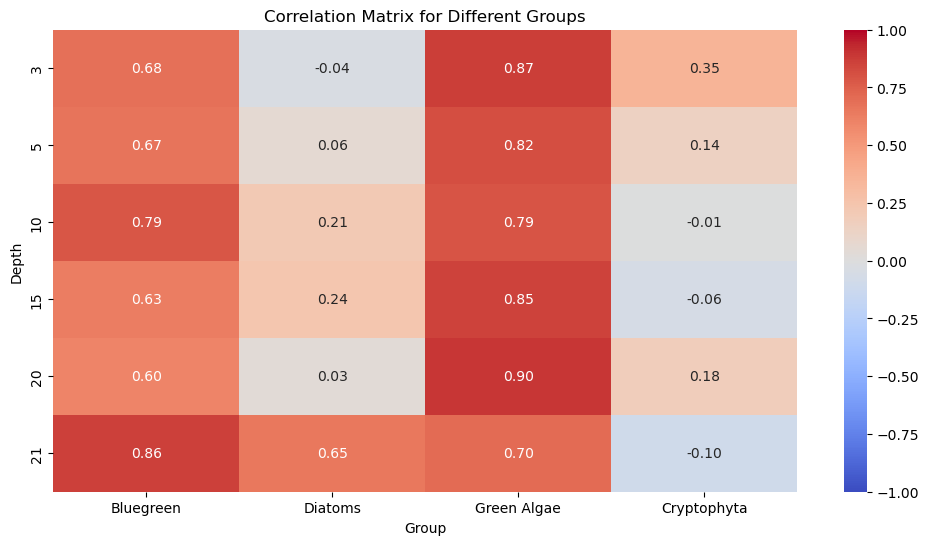

In [17]:
corr_fp_biomass_by_depth(fluor_train_df)

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def corr_fp_biomass_by_month(df):
    # Create a DataFrame containing only the relevant columns
    relevant_columns = ['month', 'group_num', 'sum_biomass_ug_ml'] + [fluor_groups_map[group_num] for group_num in fluor_groups_map.keys()]
    df_relevant = df[relevant_columns]

    # Initialize an empty dictionary to store correlation results
    correlation_results = {}

    # Loop through each group and calculate the correlation for each month
    for group_num, column_name in fluor_groups_map.items():
        # Filter the DataFrame for the current group
        group_df = df_relevant[df_relevant['group_num'] == group_num]

        # Initialize a dictionary to store correlation results for the current group
        group_correlations = {}

        # Group the data by 'month'
        grouped_by_month = group_df.groupby('month')

        # Calculate and store correlation for each month
        for month, group_data in grouped_by_month:
            correlation = group_data[['sum_biomass_ug_ml', column_name]].corr().iloc[0, 1]
            group_correlations[month] = correlation

        # Store the correlation results for the current group
        correlation_results[column_name] = group_correlations


    # Optionally, you can visualize the results in a heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(pd.DataFrame(correlation_results), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title('Correlation Matrix for Different Groups')
    plt.ylabel('Month')
    plt.xlabel('Group')
    plt.show()


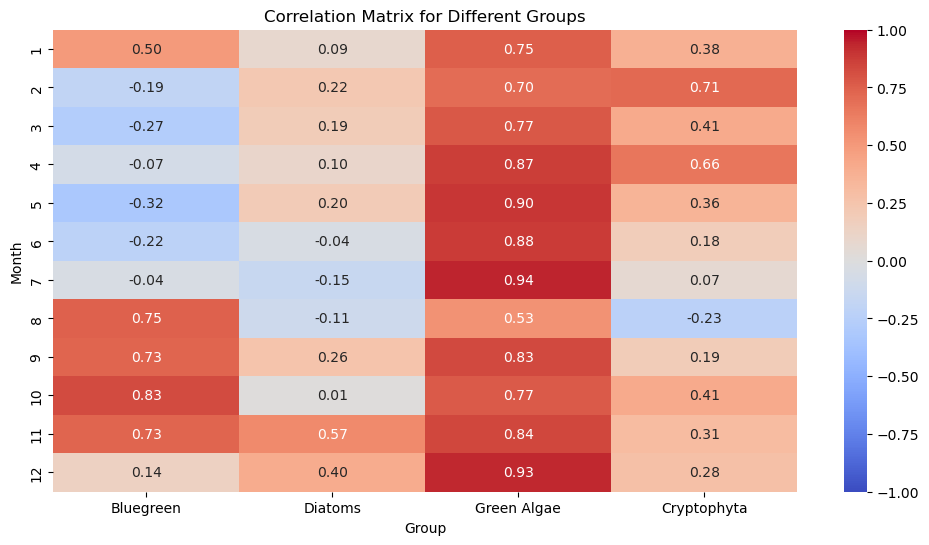

In [19]:
corr_fp_biomass_by_month(fluor_train_df)

### Exploratory Data Analysis (EDA) and Data Cleaning Processes

The goal of the analysis is to prepare the data for further modeling by addressing issues such as negative biomass values, outliers in signal values, and the need for data transformation and balancing.

1. **Removing Records with Negative Biomass**

   To ensure the integrity of the dataset, records with negative biomass values were removed. Mathematically, this process can be expressed as follows:
   
   Let $D$ represent the dataset, and $D'$ be the cleaned dataset. Then, we removed records $r$ from $D$ where $r_{\text{biomass}} < 0$, resulting in $D'$.

2. **Treating Discrete Depths**

   Due to a low number of records with discrete depths greater than or equal to 25, we made the decision to treat all records with discrete depths greater than or equal to 21 as having a discrete depth of 21. This decision was made to simplify the analysis while minimizing information loss:
   
   $
   \text{For } d \geq 21, \text{ set } d = 21.
   $

In [12]:
merged_train.shape

(68538, 18)

In [13]:
merged_train = merged_train[merged_train['sum_biomass_ug_ml'] >= 0]

In [14]:
merged_train.shape

(65795, 18)

In [15]:
merged_train.loc[merged_train['Depth'] >= 21, 'Depth'] = 21
merged_val.loc[merged_val['Depth'] >= 21, 'Depth'] = 21
merged_test.loc[merged_test['Depth'] >= 21, 'Depth'] = 21

In [16]:
signals = ['red', 'green', 'yellow', 'orange', 'violet', 'brown', 'blue', 'pressure', 'temp_sample', 'yellow_sub', 'sum_biomass_ug_ml']

3. **Visualizing Fluor-Probe Signals Using Boxplots**

   We visualized each of the fluor-probe signals using boxplots. The signals of interest include: red, green, yellow, orange, violet, brown, blue, pressure, temp_sample, yellow_sub, and sum_biomass_ug_ml. Boxplots provide a clear summary of the distribution of these signals.


4. **Removing Records with Outlier Signal Values**

   Outliers in signal values were identified and removed based on predefined boundaries for each signal. The boundaries are represented as lower and upper bounds:

   $
   \text{For each signal } S, \text{ remove records where } S < \text{lower bound} \text{ or } S > \text{upper bound}.
   $

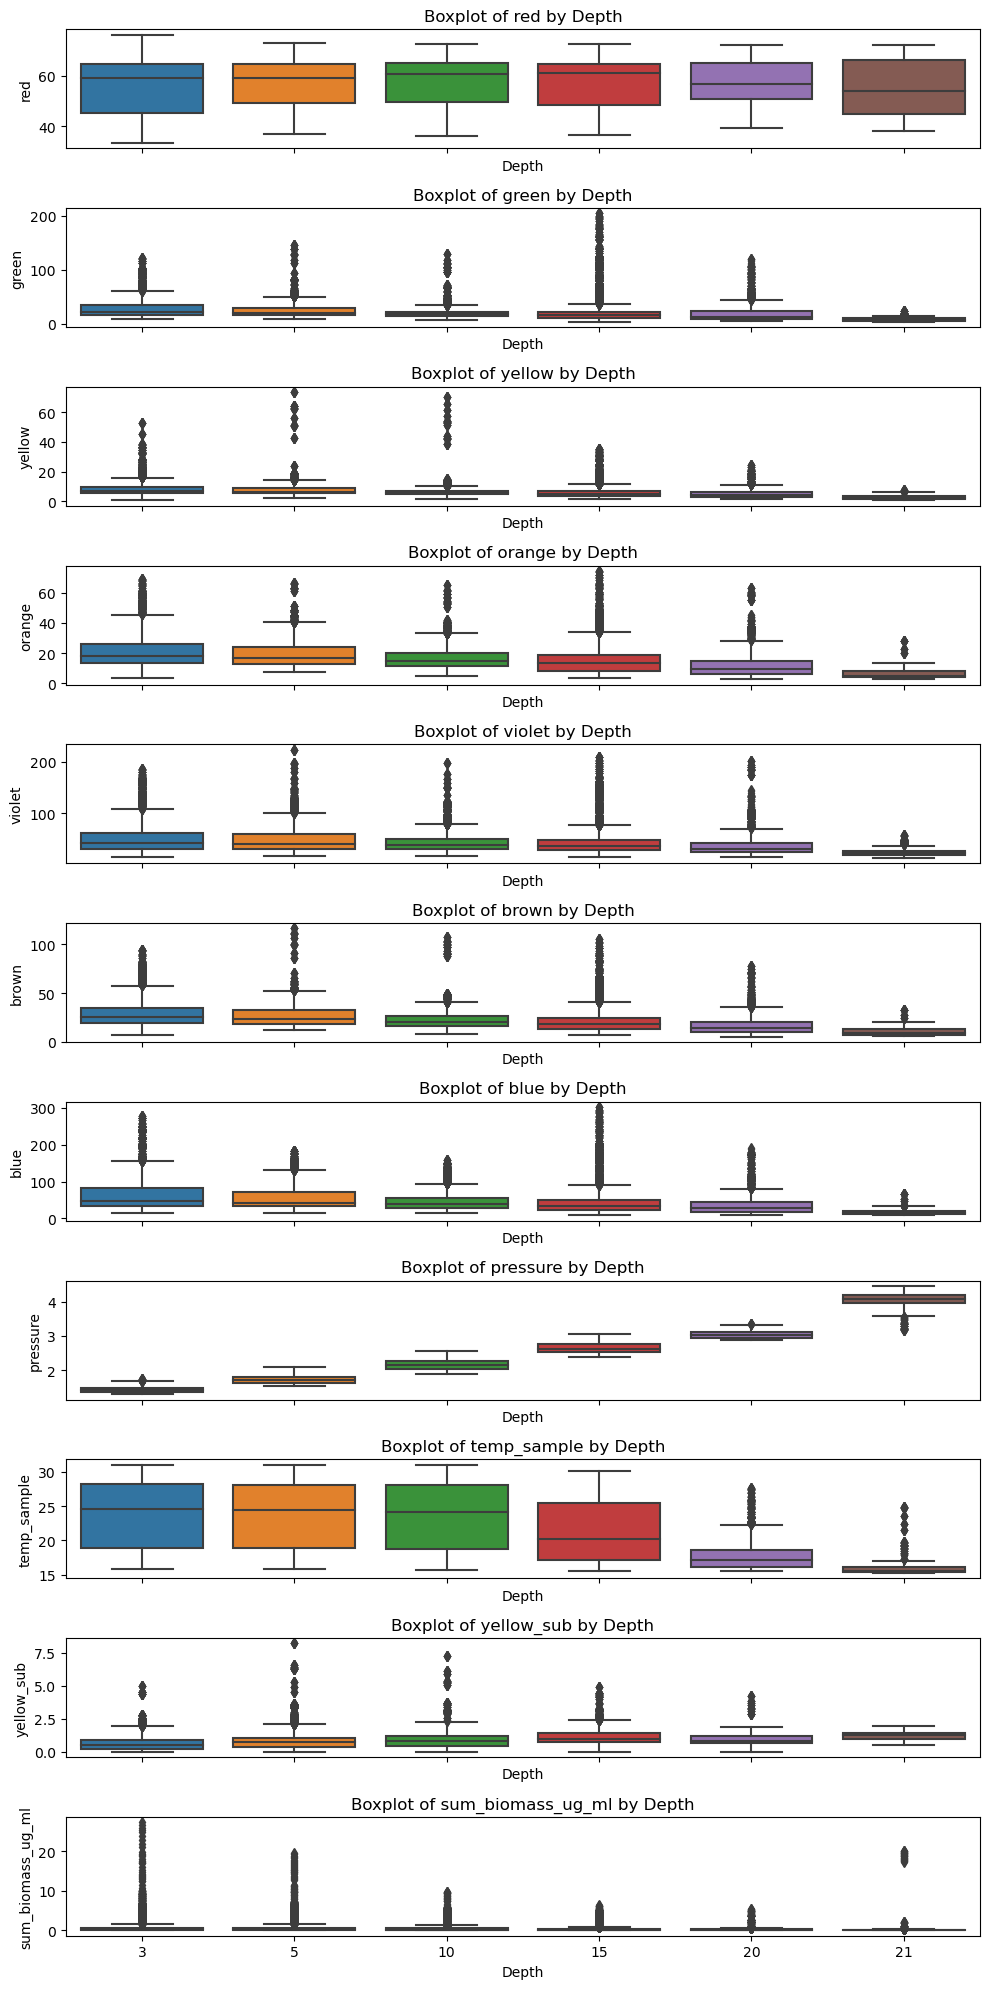

In [17]:
boxplot_by_depth(merged_train, signals, by_col='Depth')

In [18]:
signals.remove('sum_biomass_ug_ml')
signals.remove('pressure')
signals.remove('temp_sample')
boundaries = {
    'red': {'lower_bound': 0, 'upper_bound': 120},
    'green': {'lower_bound': 0, 'upper_bound': 100},
    'yellow': {'lower_bound': 0, 'upper_bound': 40},
    'orange': {'lower_bound': 0, 'upper_bound': 60},
    'violet': {'lower_bound': 0, 'upper_bound': 150},
    'brown': {'lower_bound': 0, 'upper_bound': 80},
    'blue': {'lower_bound': 0, 'upper_bound': 220},
    'yellow_sub': {'lower_bound': 0, 'upper_bound': 7}
}

filter_signals_by_boundaries(merged_train, signals, boundaries)

In [19]:
merged_train.shape

(64642, 18)

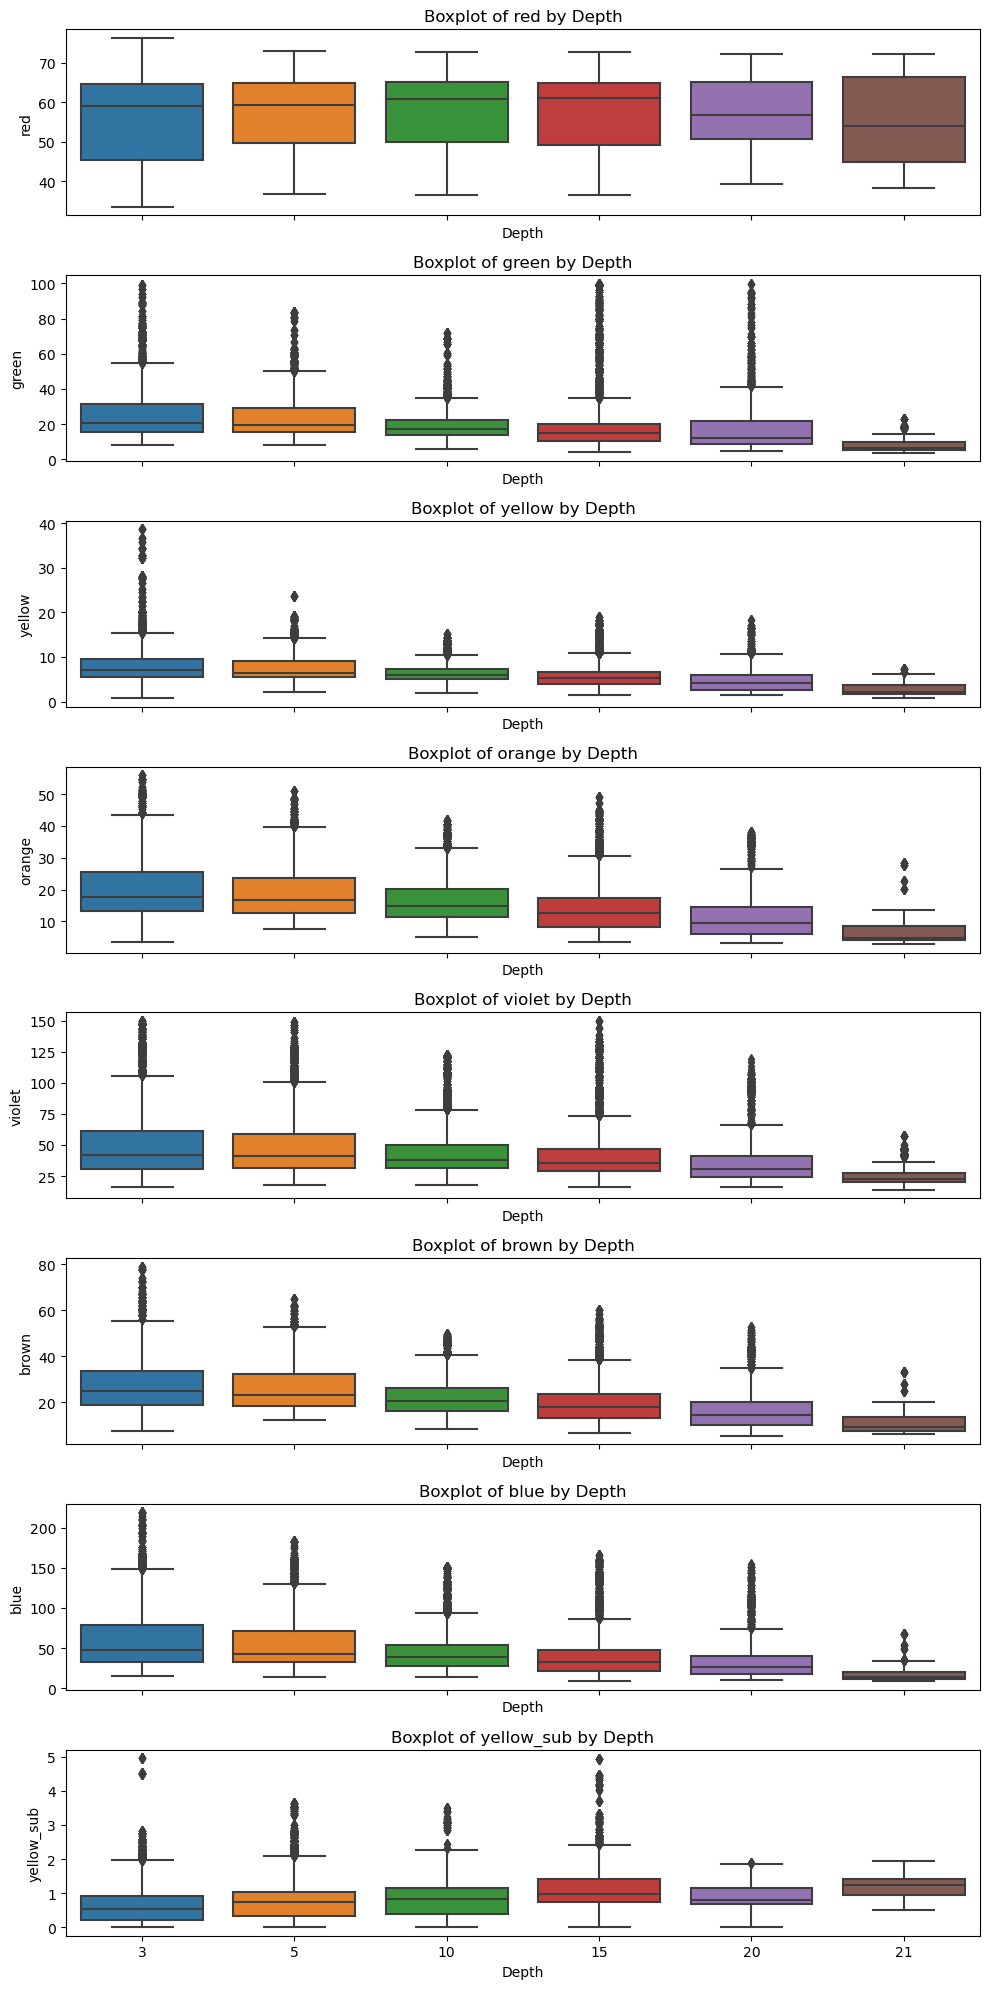

In [20]:
boxplot_by_depth(merged_train, signals, by_col='Depth')

5. **Visualizing Biomass Values of Phytoplankton Groups**

   We visualized the biomass values of each phytoplankton group using boxplots and violin graphs. These visualizations provide insights into the distribution of biomass values for different phytoplankton groups.


6. **Log Transformation of Biomass Values**

   Based on the boxplots, it was observed that the distribution of biomass values was skewed. To make the data more suitable for modeling, a log transformation was applied to the biomass values:

   $
   \text{For each record } r, \text{ set } r_{\text{biomass}} = \log(r_{\text{biomass}}).
   $

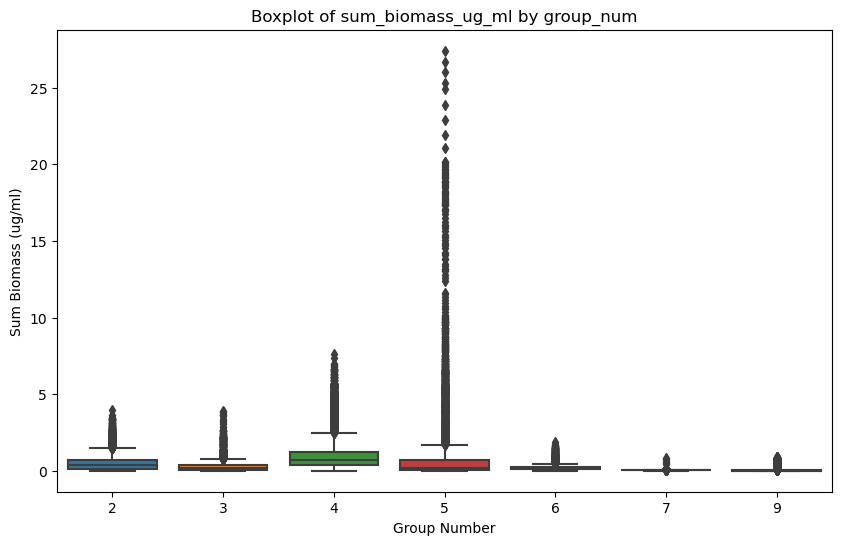

In [21]:
boxplot_biomass_by_group(merged_train)

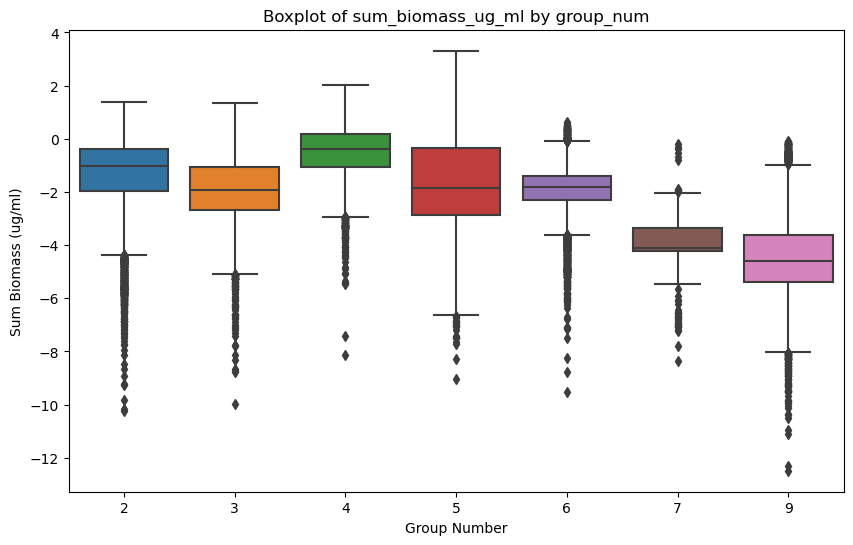

In [23]:
merged_train['sum_biomass_ug_ml'] = merged_train['sum_biomass_ug_ml'].apply(np.log)
boxplot_biomass_by_group(merged_train)

7. **Balancing Biomass Values Using SMOGN Method**

   Based on the violin plots, it was evident that the biomass values for different phytoplankton groups were imbalanced. To address this issue, the Synthetic Minority Over-sampling Technique for Regression (SMOGN) method was employed to balance the biomass values within each phytoplankton group.

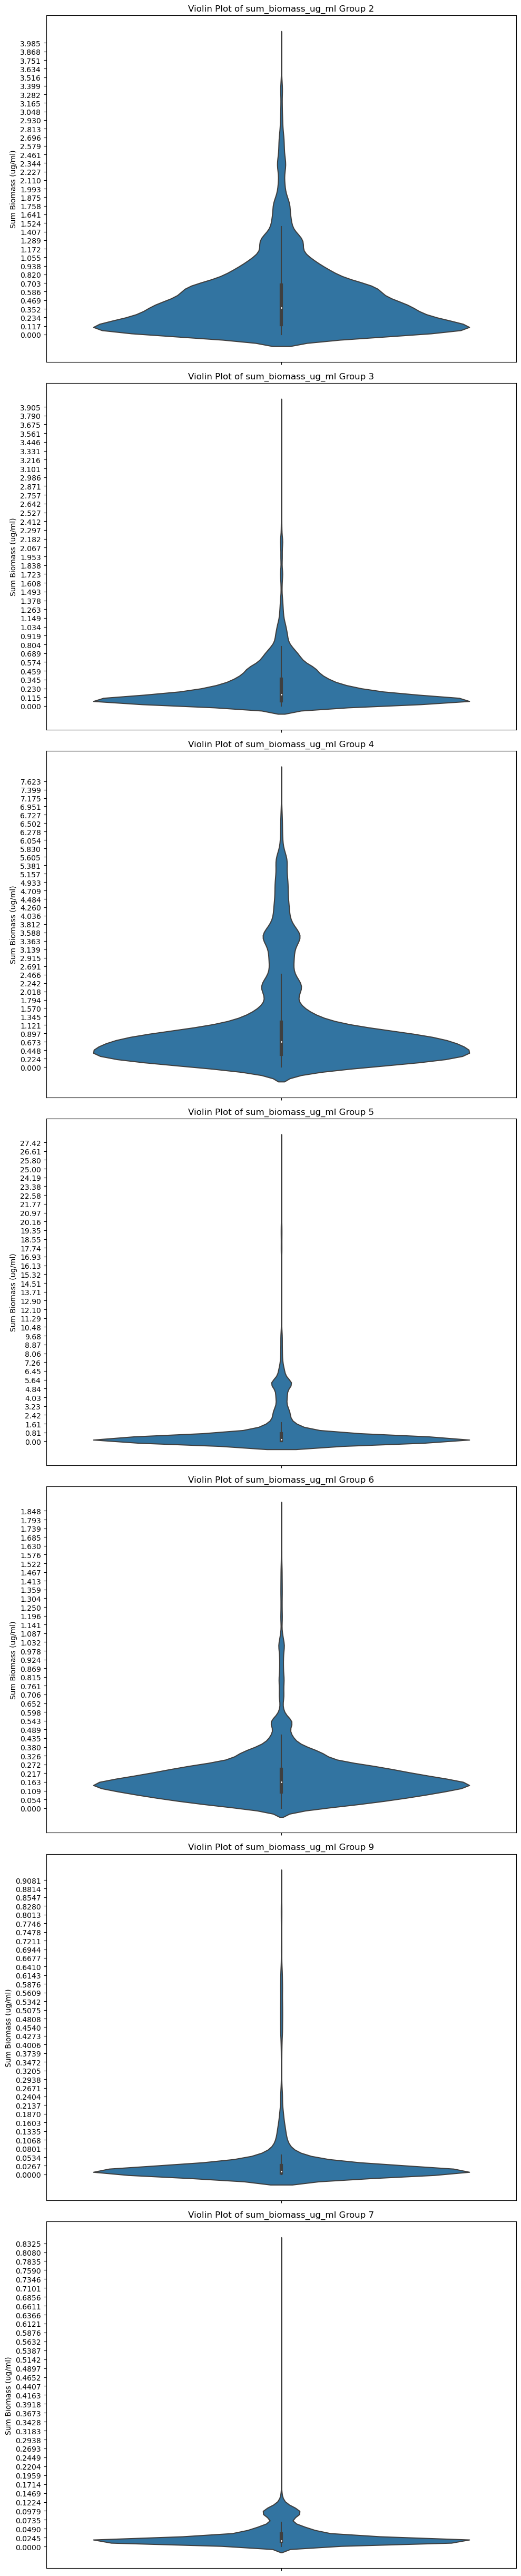

In [22]:
violin_biomass_by_group(merged_train)

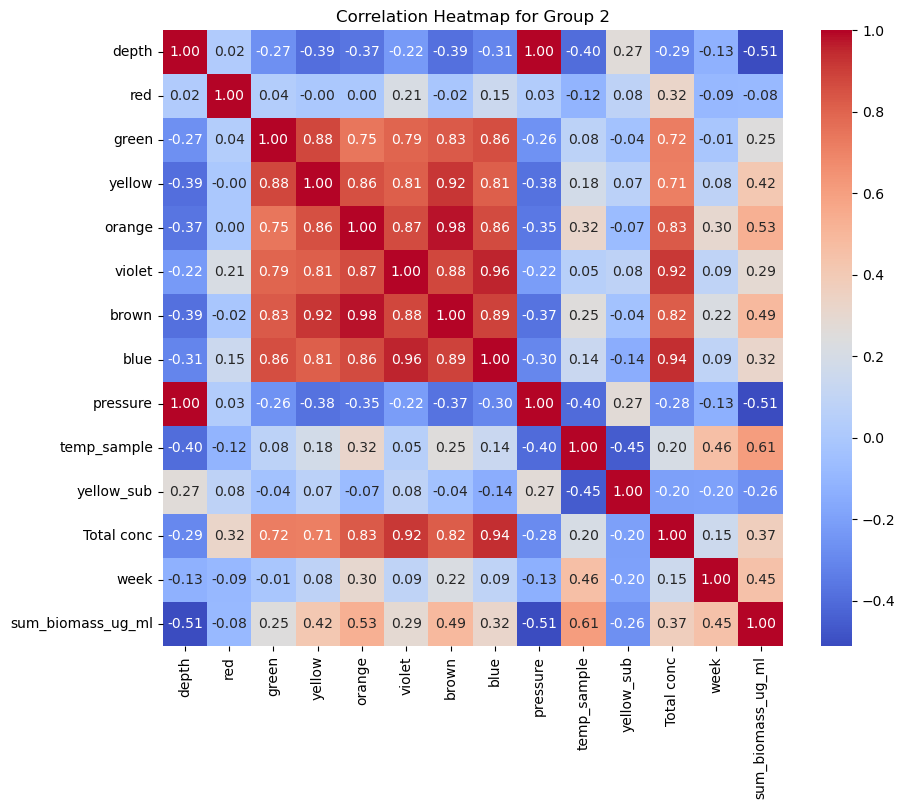

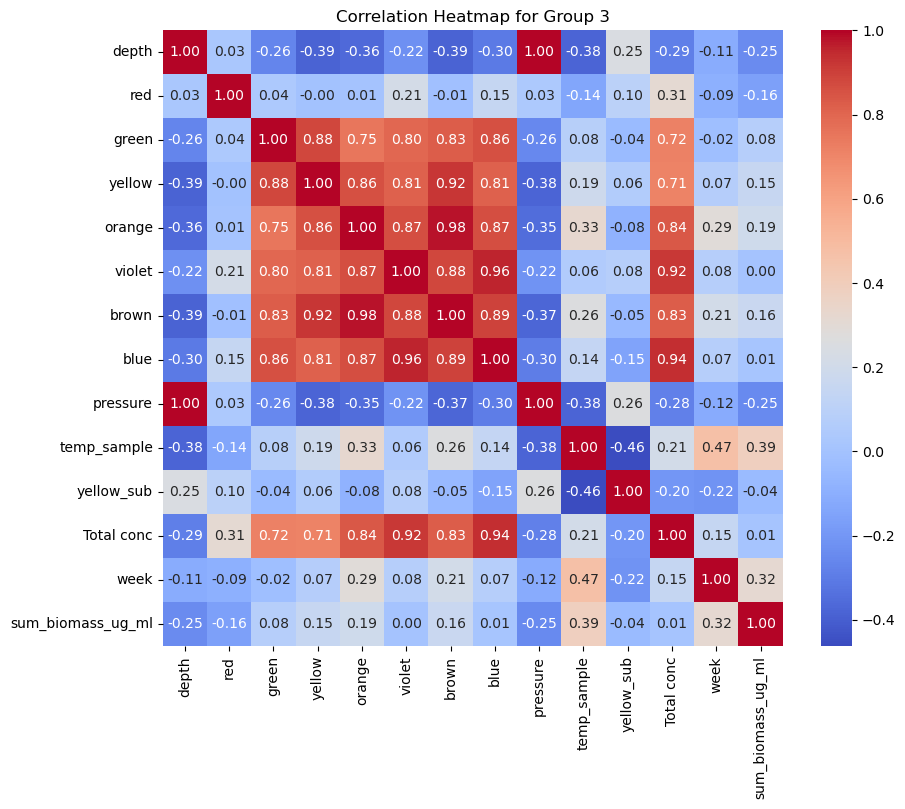

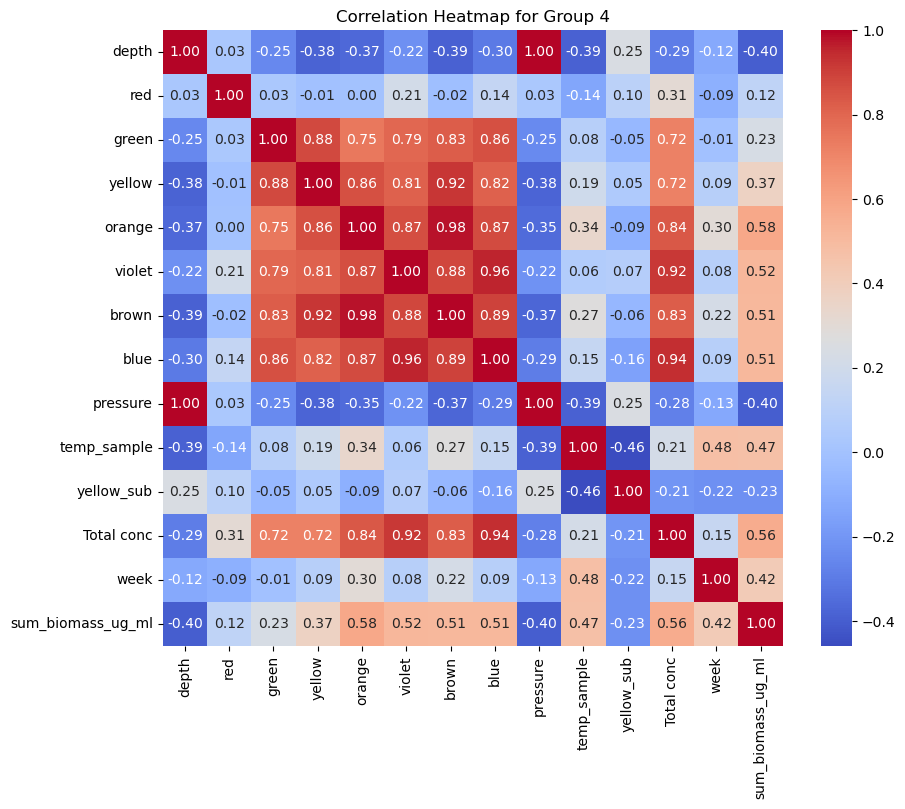

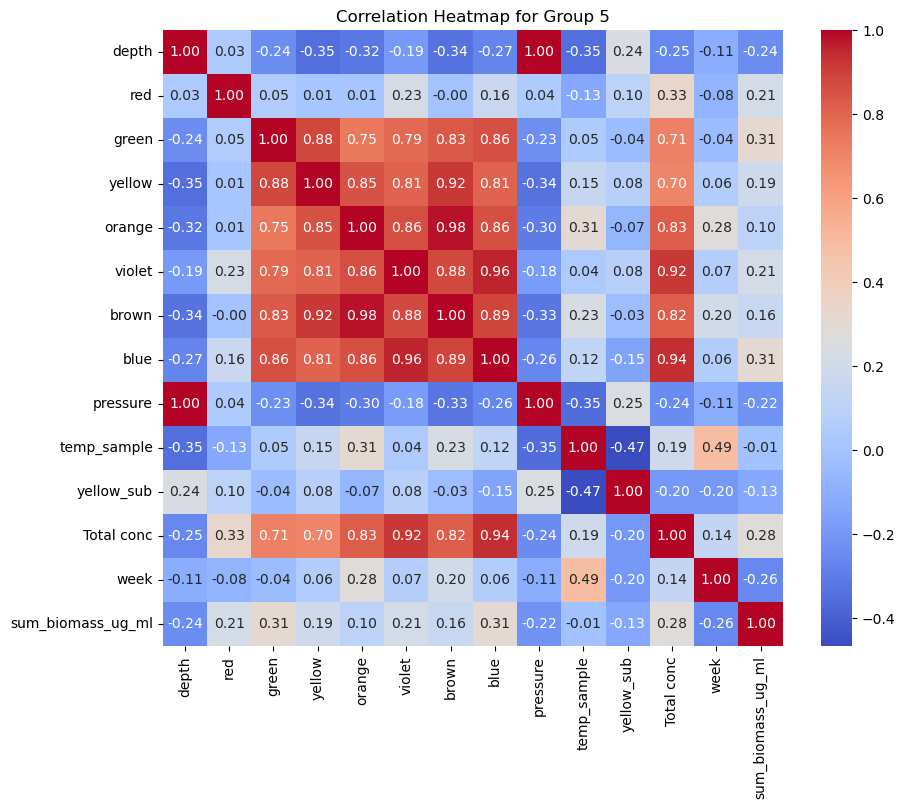

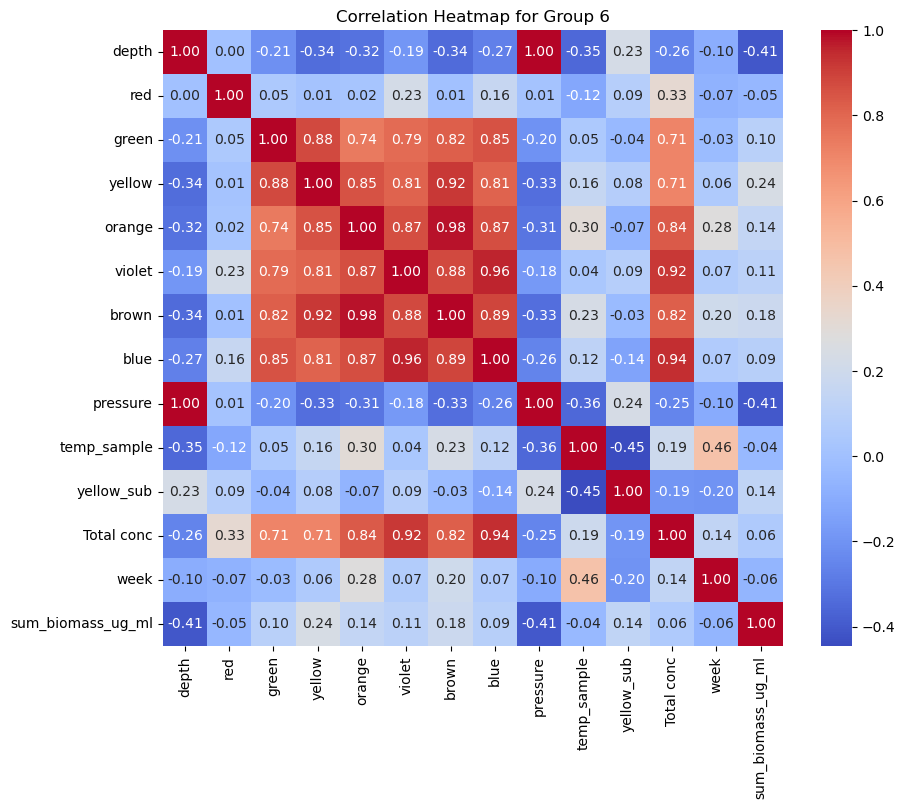

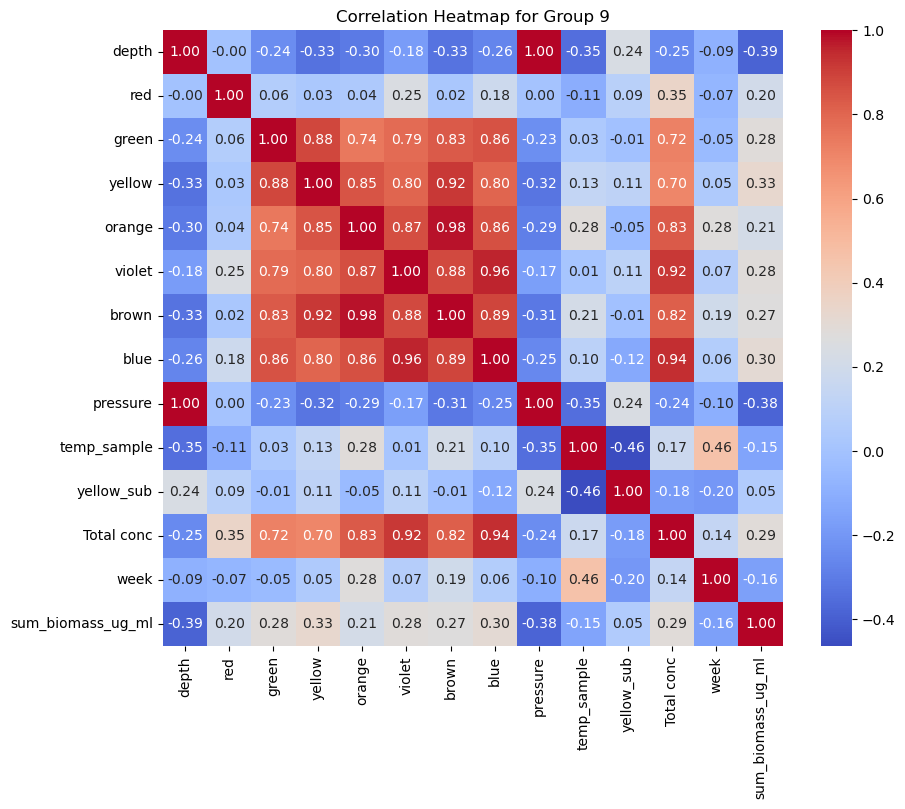

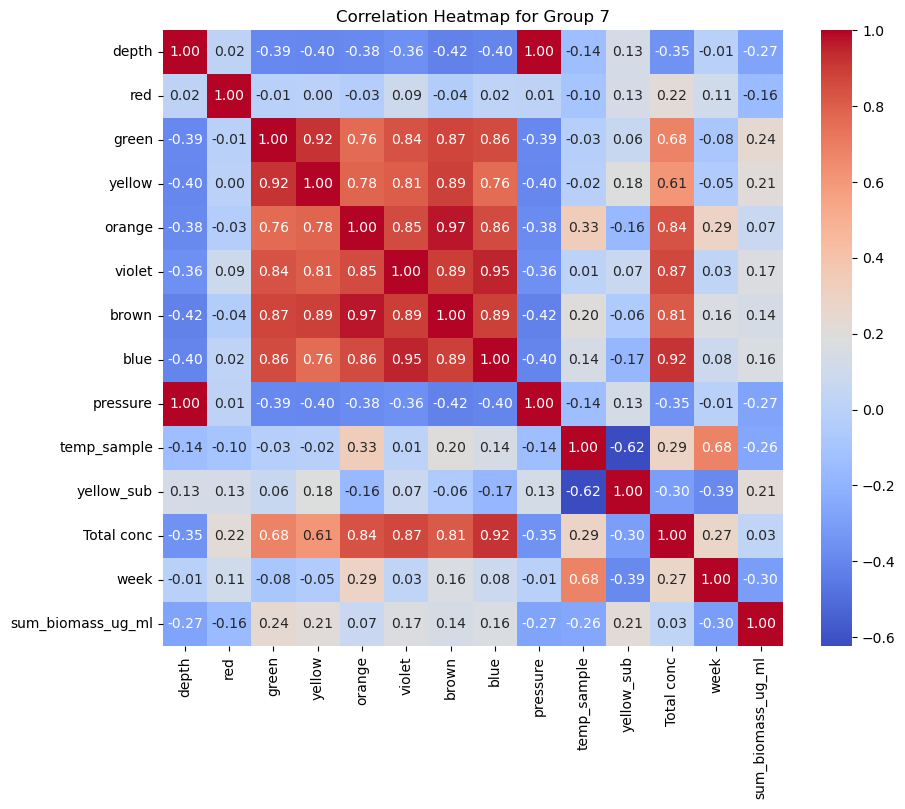

In [24]:
correlation_per_group(merged_train)

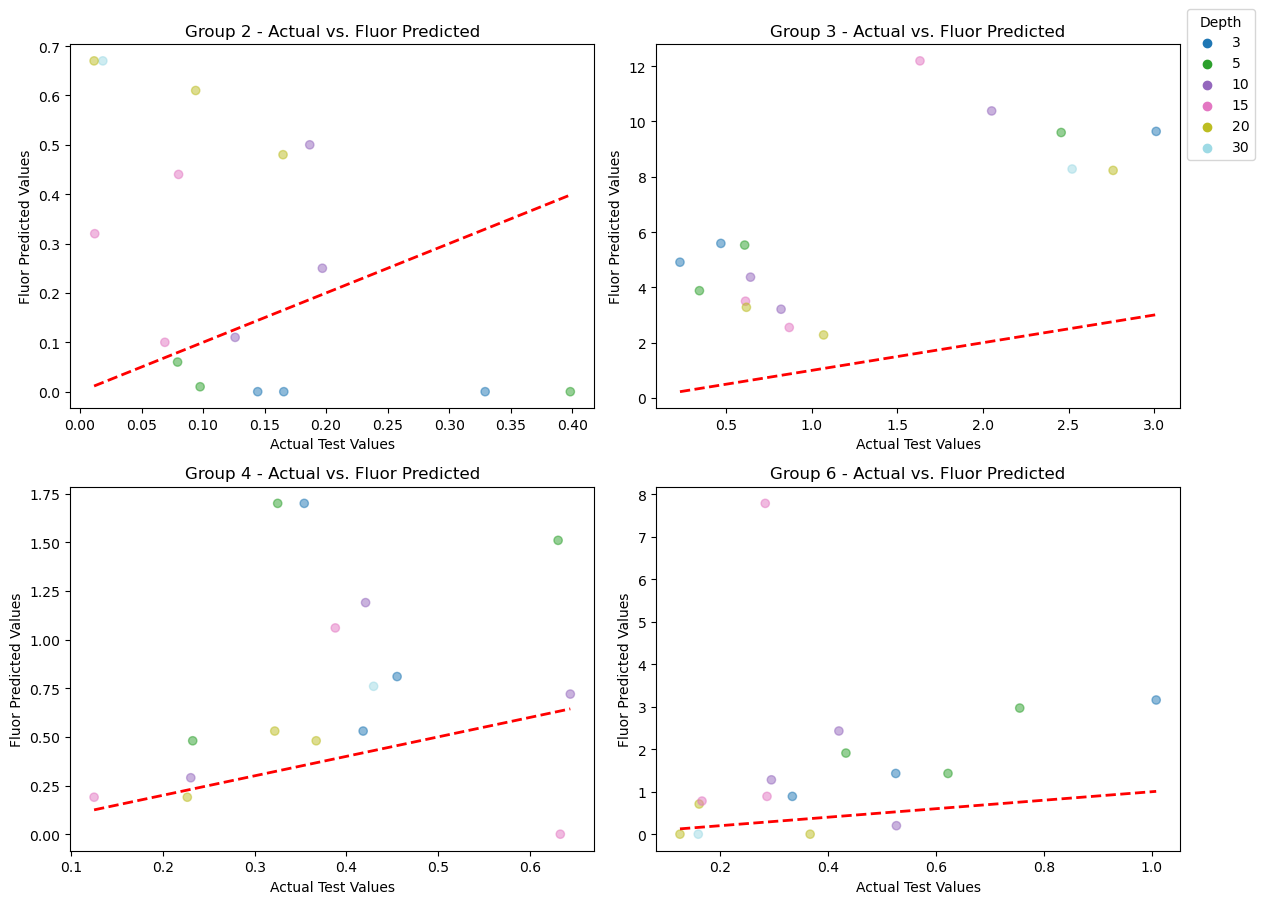

In [25]:
plot_fluorprobe_prediction(fluor_val_df, fluor_groups_map)

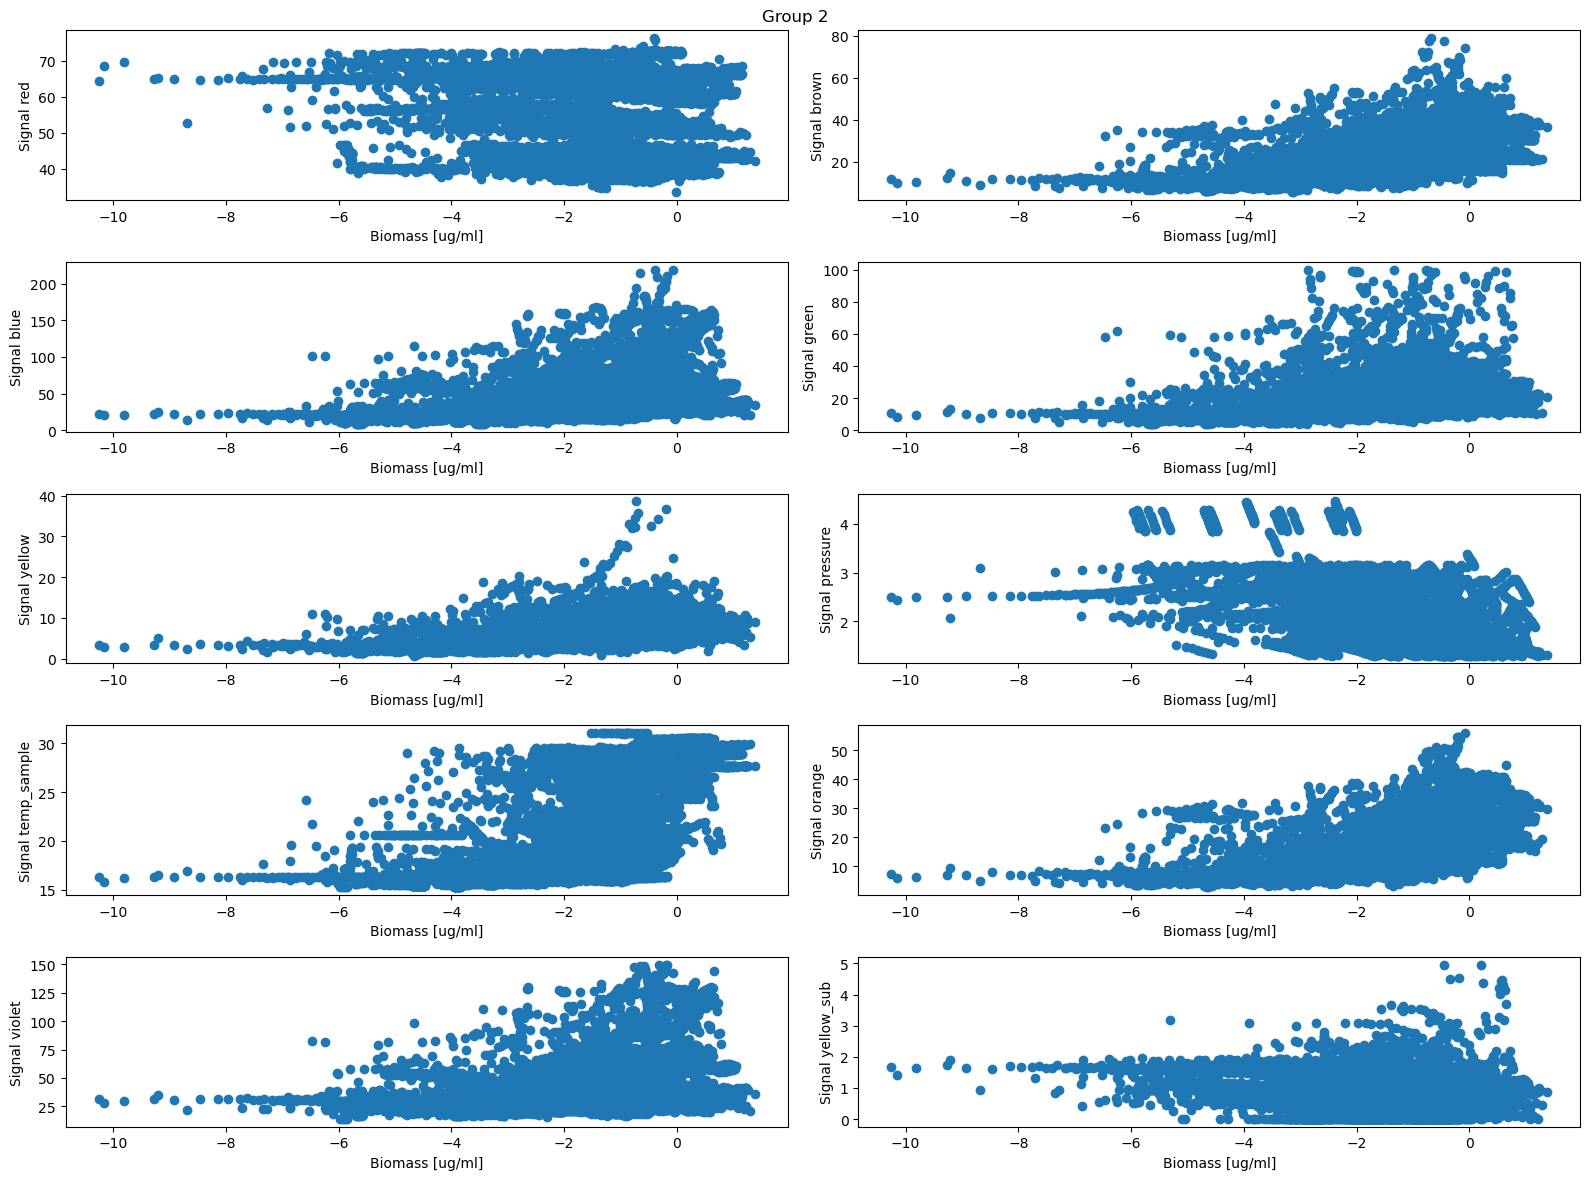

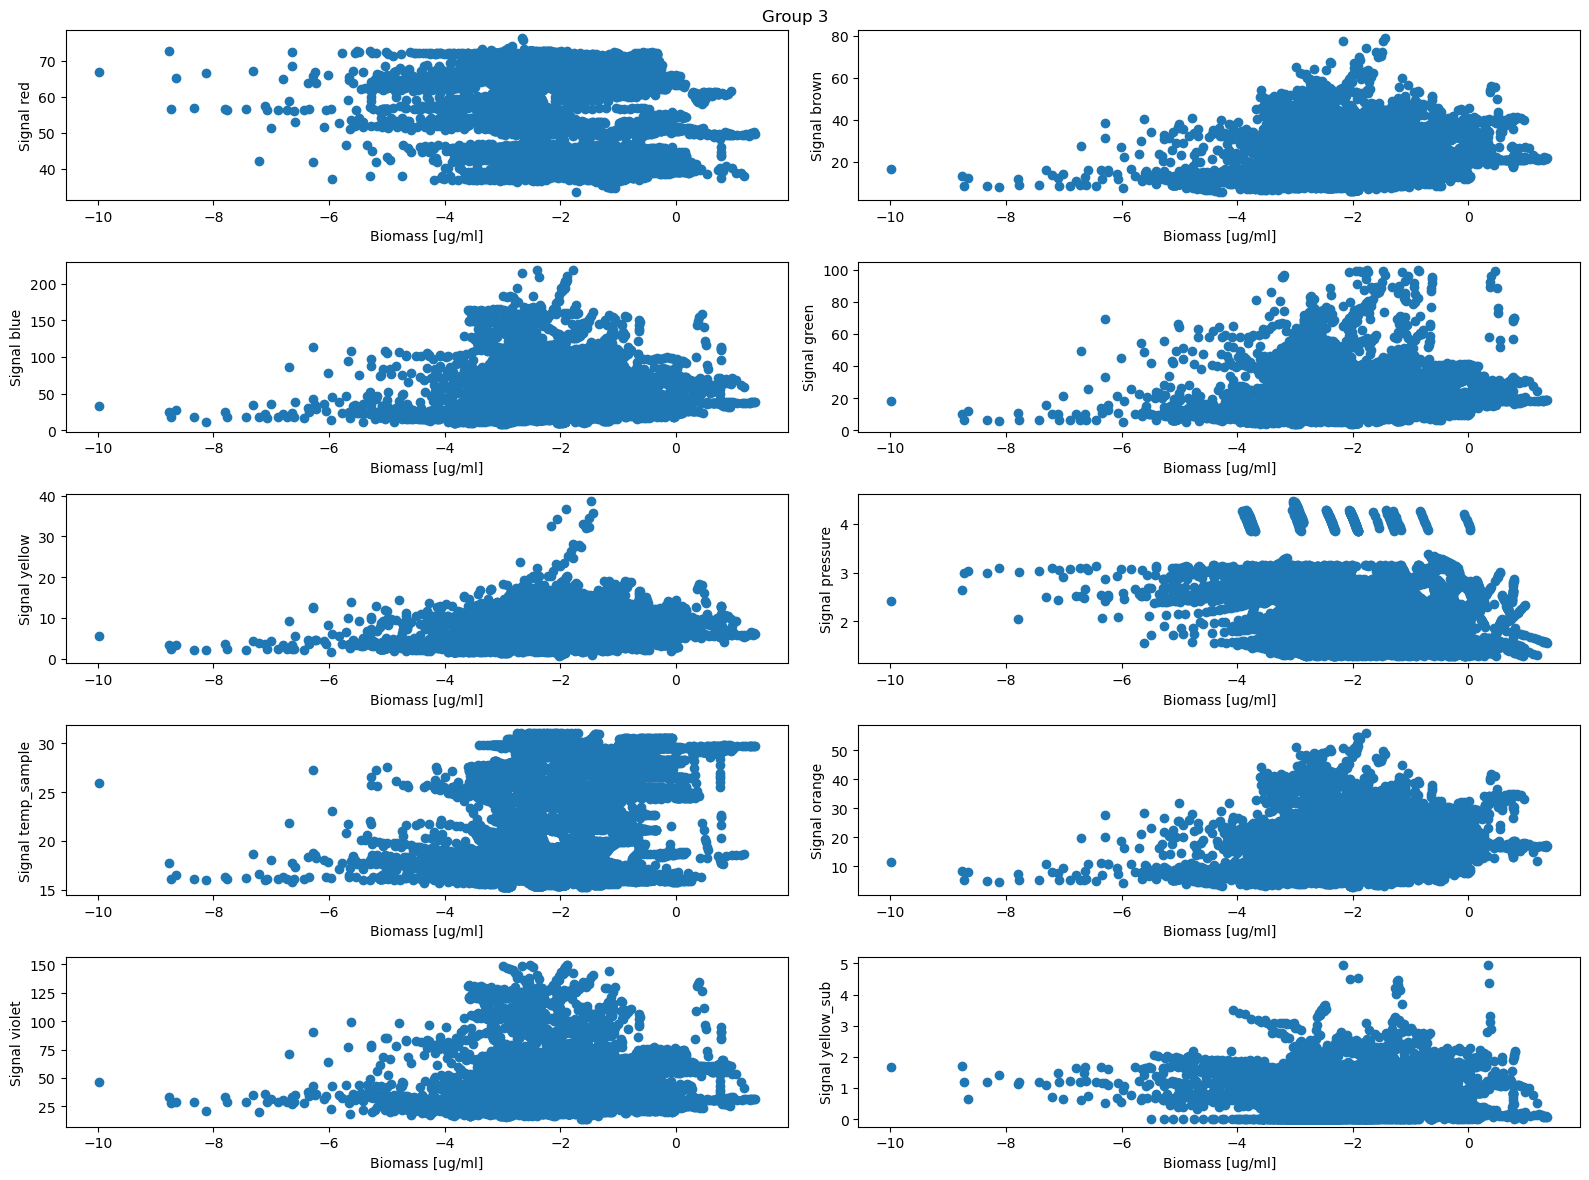

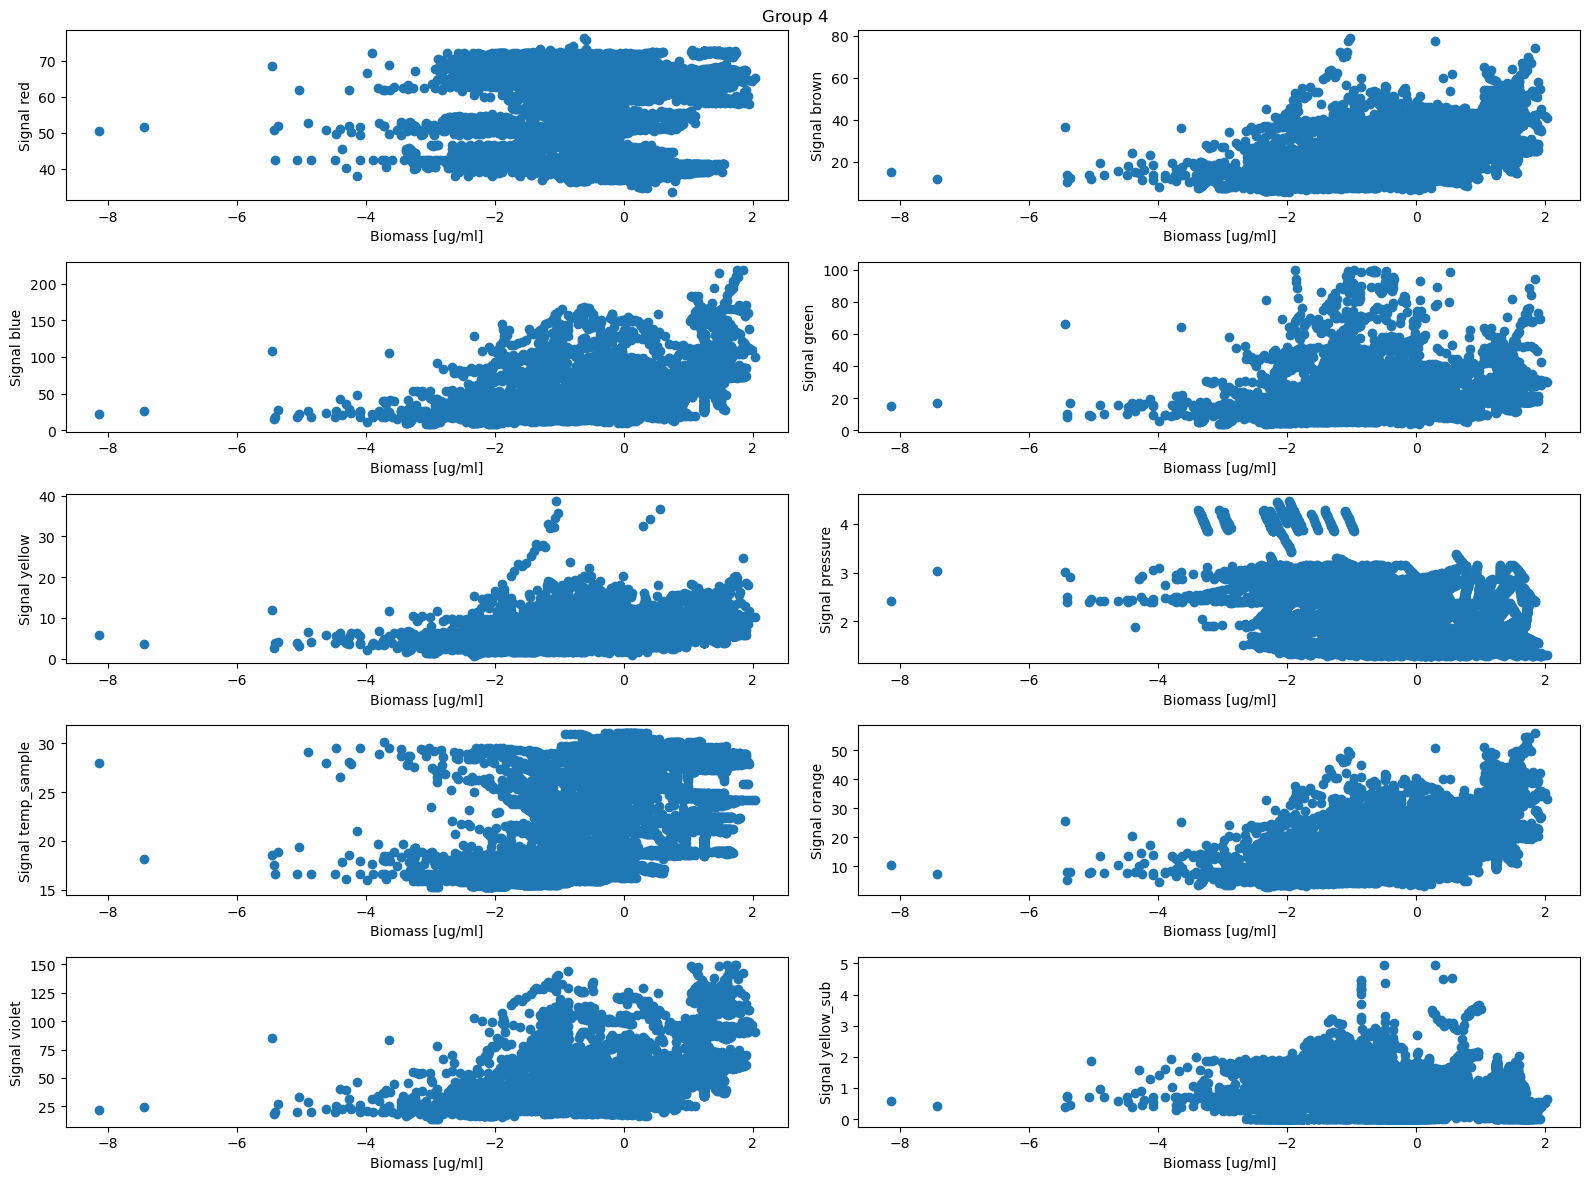

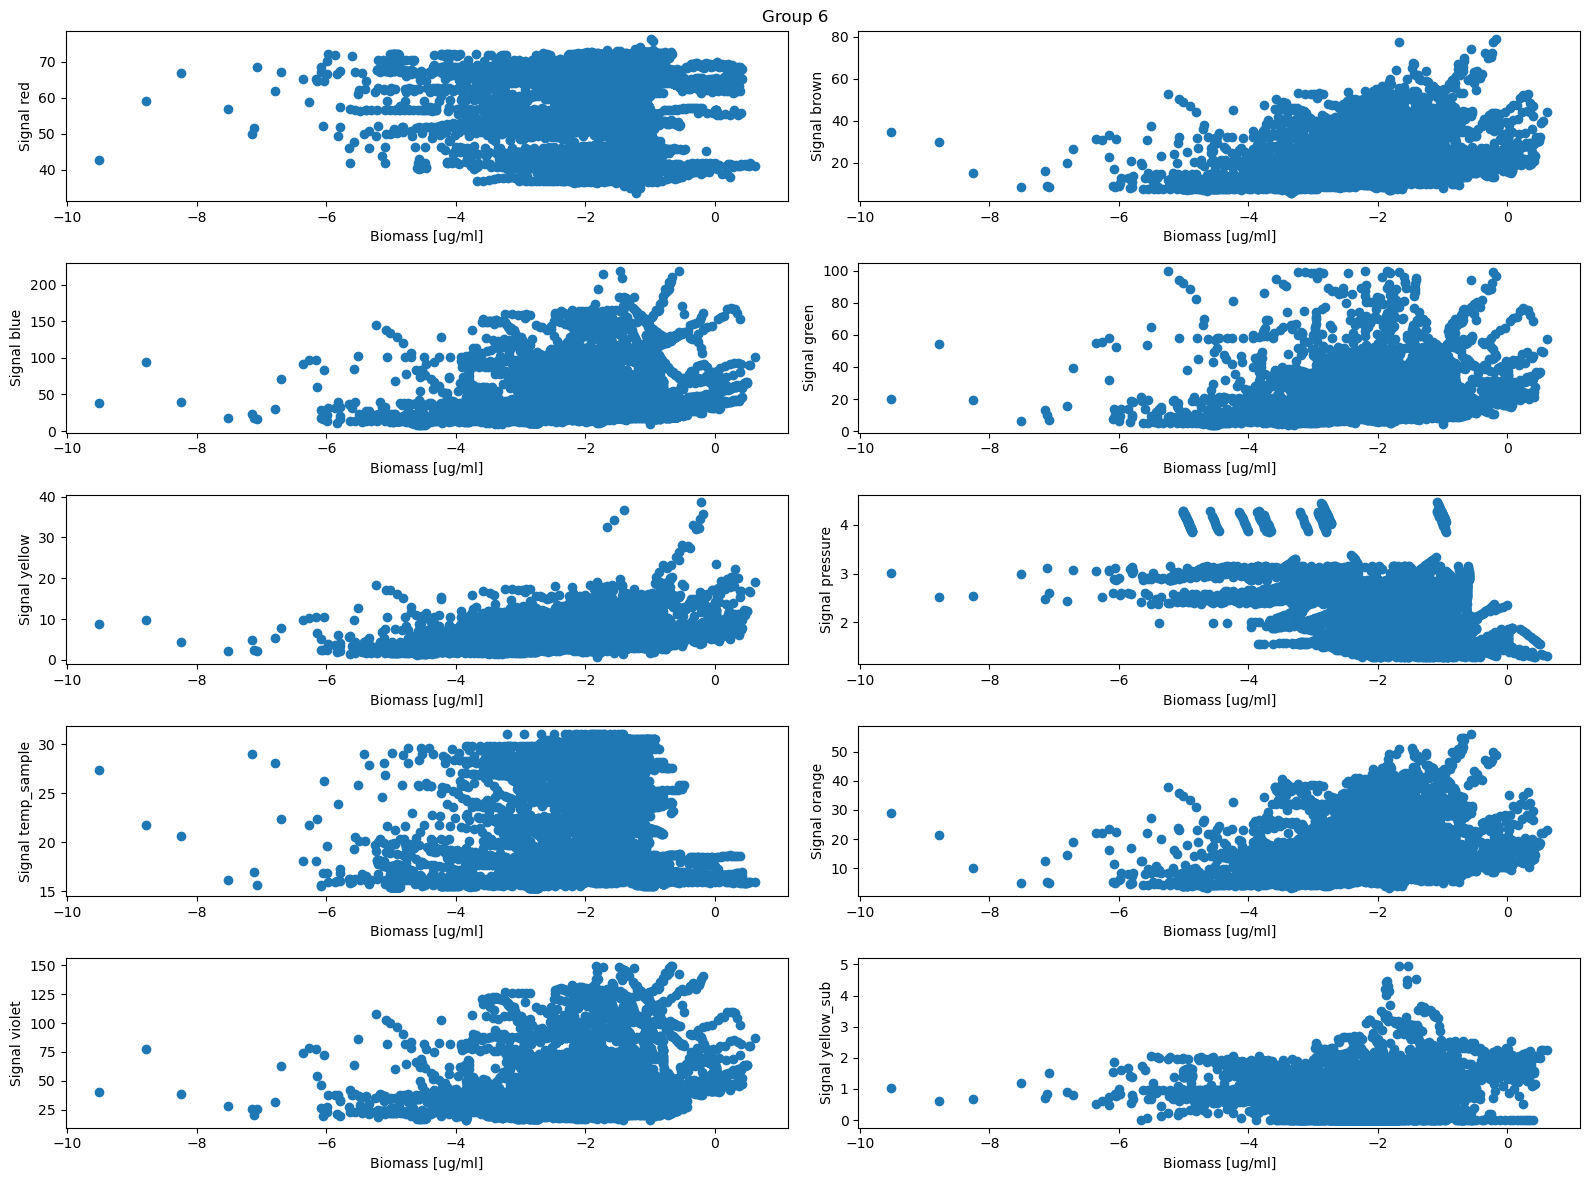

In [26]:
plot_corr_per_feature_per_group(merged_train, fluor_groups_map)

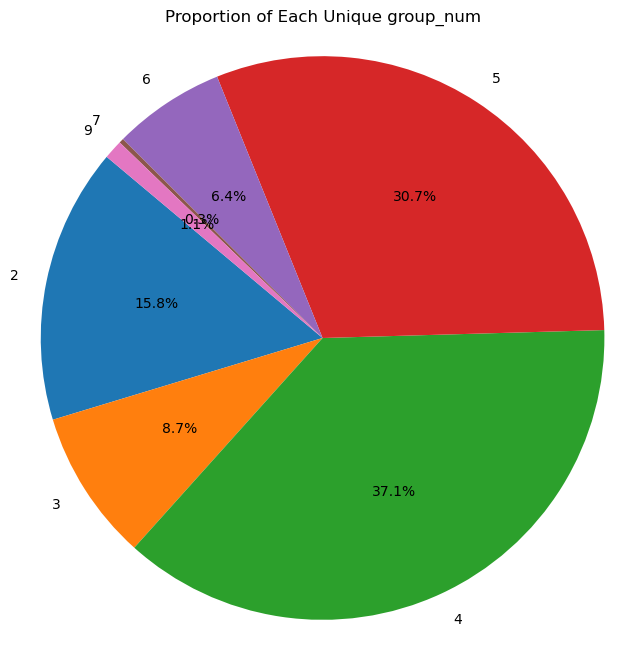

In [27]:
merged_train['sum_biomass_ug_ml'] = merged_train['sum_biomass_ug_ml'].apply(np.exp)
groups_pie_chart(merged_train, by_biomass=True)

In [28]:
# merged_train = merged_train.drop(['year', 'Depth', 'depth', 'week', 'month'], axis=1)
# orig_merged_train = orig_merged_train.drop(['year', 'Depth', 'depth', 'week', 'month'], axis=1)

# TODO: Check the addition of month
merged_train = merged_train.drop(['year', 'Depth', 'depth', 'week'], axis=1)
orig_merged_train = orig_merged_train.drop(['year', 'Depth', 'depth', 'week'], axis=1)

# Hyperparameter Grid Search for Model Training

We employed a hyperparameter grid search to fine-tune the performance of three different models: XGBoost (XGB), Support Vector Regression (SVR), and ElasticNet (ELF). The goal of this grid search was to optimize the models' hyperparameters in order to minimize the Mean Squared Error (MSE), a common measure used in regression tasks. To achieve this objective, we aimed to maximize the negative MSE, as a higher negative MSE corresponds to a lower real MSE.


## XGBoost (XGB)

### Hyperparameters Explored:
We conducted a grid search over the following hyperparameters for the XGBoost model:

- `n_estimators`: This parameter represents the number of boosting rounds, which controls the number of decision trees in the ensemble.
- `max_depth`: It determines the maximum depth of each tree in the ensemble.
- `alpha`: The alpha parameter is related to L1 (Lasso) regularization, which helps prevent overfitting by adding a penalty for large coefficients.
- `lambda`: Lambda is the mixing parameter between L1 (Lasso) and L2 (Ridge) regularization. It balances the contribution of L1 and L2 regularization terms.

the XGBoost model aims to find the optimal values for these hyperparameters by minimizing the negative MSE, which is defined as:

$ \text{Negative MSE} = -\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 \$

Where:
- $N$ is the number of data points.
- $y_i$ represents the actual target value for the \(i\)-th data point.
- $\hat{y}_i$ is the predicted target value for the \(i\)-th data point using the XGBoost model.

## Support Vector Regression (SVR)

### Hyperparameters Explored:
For the SVR model, our grid search explored the following hyperparameters:

- `C`: This is the regularization parameter, which controls the trade-off between fitting the training data and preventing overfitting.
- `tol`: The tolerance for stopping criterion, which determines when to stop the training process.


## ElasticNet (ELF)

### Hyperparameters Explored:
For the ElasticNet model, we explored the following hyperparameters in our grid search:

- `alpha`: This is the regularization parameter, which combines both L1 (Lasso) and L2 (Ridge) regularization.
- `l1_ratio`: The l1_ratio parameter determines the mixing ratio between L1 and L2 regularization terms.

In [29]:
pickled_params = 'best_grid_params.pkl'
do_search = not os.path.exists(pickled_params)

def two_scorer(mse=False):
    score = mean_squared_error if mse else r2_score
    return make_scorer(score, greater_is_better=mse==False)

In [30]:
if do_search:
    param_grid_per_model = {'xgb': {
        "model__n_estimators": [100, 300, 500], # Number of boosting rounds
        "model__max_depth": [2, 3, 5], # Maximum depth of a tree,
        "model__alpha": [0.01, 0.1, 1, 10], # L1 regularization term
        "model__lambda": [0, 0.2, 0.8], # Mixing parameter between L1 and L2 regularization
    },
    'svr':  {
        "model__C": [0.001, 0.1, 1, 10, 100], # Regularization parameter
        "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
    },
    'elf': {
        "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
        "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
    }}
    
    best_group_params_per_model = {}
    for model_name, param_grid in param_grid_per_model.items():
        best_group_params_per_model[model_name] = grid_search_cv(model_name, merged_train, param_grid=param_grid,
                                                                scoring_method=two_scorer(mse=True))
    
    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model, f)
    
    best_group_params_per_model_fixed = {}
    for model_name, kwargs_per_group in best_group_params_per_model.items():
        best_group_params_per_model_fixed[model_name] = {}
        for group_num in kwargs_per_group.keys():
            best_group_params_per_model_fixed[model_name][group_num] = {}
            kwargs = kwargs_per_group[group_num]
            for param, val in kwargs.items():
                fixed_param = param.split('model__')[1]
                best_group_params_per_model_fixed[model_name][group_num][fixed_param] = val


    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model_fixed, f)

else:
    with open(pickled_params, 'rb') as f:
        best_group_params_per_model_fixed = pickle.load(f)

In [31]:
regression_models = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models[model_name], _ = train(model_name, merged_train, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models['lr'], _ = train('lr', merged_train, test_size=0.0, biomass_fn=np.log)

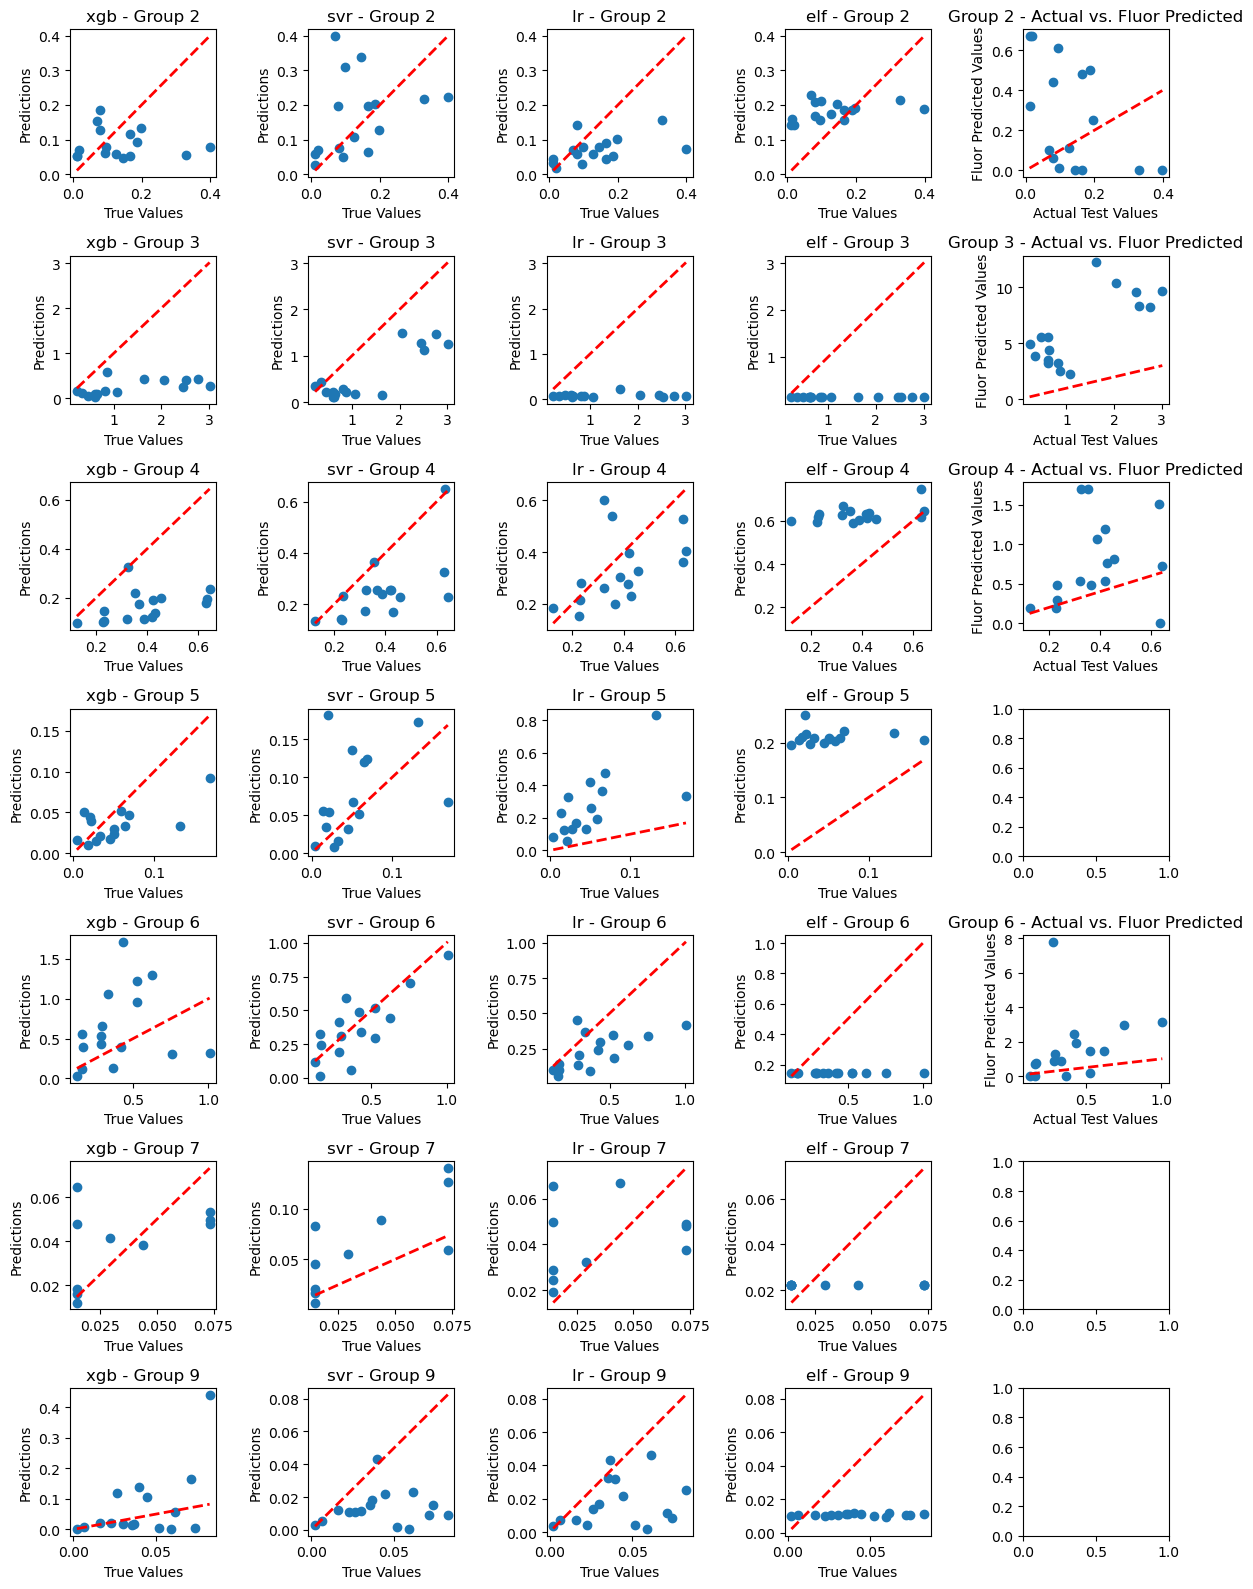

In [32]:
comparing_df = compare_all_models(regression_models, merged_val.drop(['year', 'Depth', 'week'], axis=1), fluor_val_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr', 'lr', 'elf'])

In [33]:
cleaned_res = compare_by_mpe(merged_val, regression_models, predict_cols=merged_train.drop(['sum_biomass_ug_ml', 'group_num'], axis=1).columns, predict_fn=np.exp)

In [34]:
fp_res = calc_mpe_fp(fluor_val_df, with_group_5=False)

# With SMOGN

In [35]:
import smogn
import seaborn

In [36]:
smogn_file = './data/smogn_merged_train_with_7_9.pkl'
do_smogn = not os.path.exists(smogn_file)

In [37]:
if do_smogn:
    merged_train_smogn = []
    for group_num in merged_train['group_num'].unique():
        group_df = merged_train[merged_train['group_num'] == group_num]
        print(f'********Group {group_num}************')
        print(group_df.shape)
        group_df_smogn = smogn.smoter(
            data = group_df.reset_index(drop=True),  ## pandas dataframe
            y = 'sum_biomass_ug_ml'  ## string ('header name')
        )
        print(group_df_smogn.shape)

        ## plot y distribution 
        plt.figure(figsize=(8, 6))
        seaborn.kdeplot(group_df['sum_biomass_ug_ml'], label = "Original")
        seaborn.kdeplot(group_df_smogn['sum_biomass_ug_ml'], label = "Modified")
        plt.legend()
        plt.show()

        merged_train_smogn.append(group_df_smogn)


    merged_train_smogn_concat = pd.concat(merged_train_smogn, ignore_index=True)
    with open(smogn_file, 'wb') as f:
        pickle.dump(merged_train_smogn_concat, f)
        
else:
    with open(smogn_file, 'rb') as f:
        merged_train_smogn_concat = pickle.load(f)

In [38]:
regression_models_smogn = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models_smogn[model_name], _ = train(model_name, merged_train_smogn_concat, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models_smogn['lr'], _ = train('lr', merged_train_smogn_concat, test_size=0.0, biomass_fn=np.log)

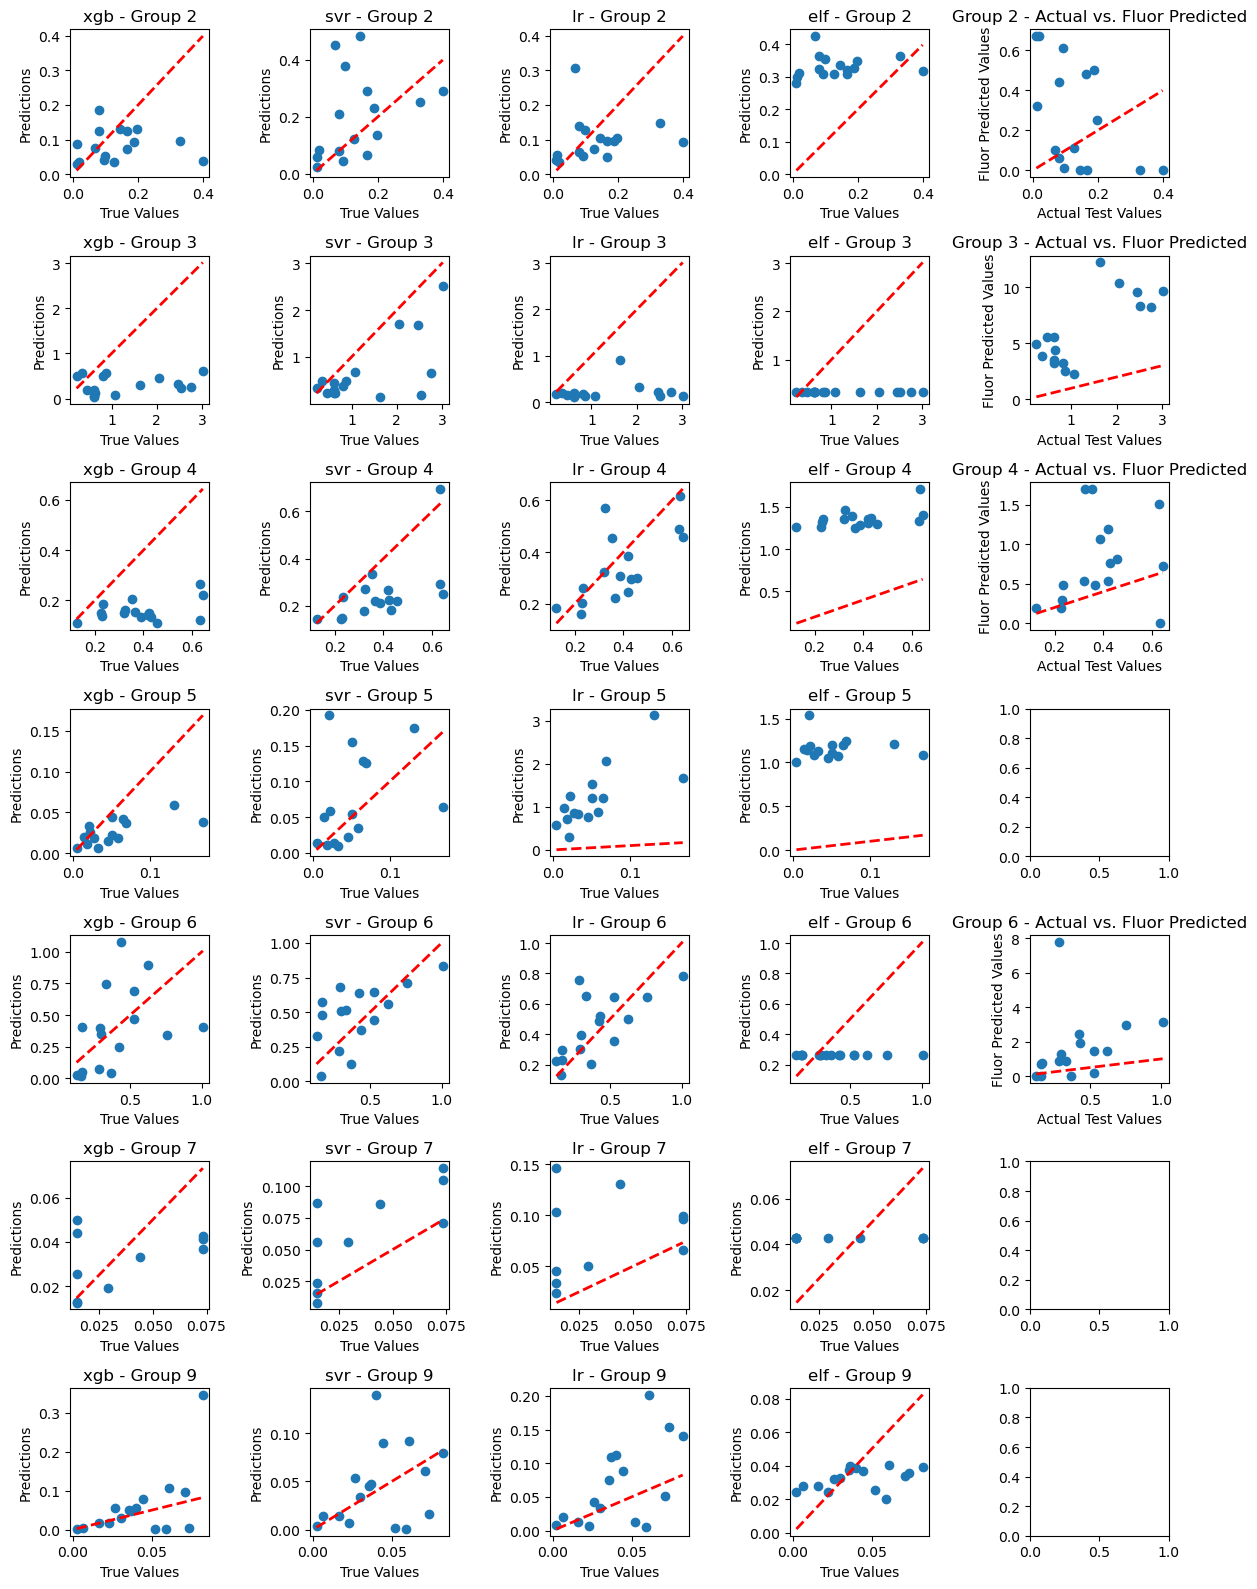

In [39]:
comparing_df_smogn = compare_all_models(regression_models_smogn, merged_val.drop(['year', 'Depth', 'week'], axis=1), fluor_val_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr', 'lr', 'elf'])

In [40]:
cleaned_smogn_res = compare_by_mpe(merged_val, regression_models_smogn, predict_cols=merged_train.drop(['sum_biomass_ug_ml', 'group_num'], axis=1).columns, predict_fn=np.exp)

# No Outliers Removal

In [41]:
regression_models_orig = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models_orig[model_name], _ = train(model_name, orig_merged_train, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models_orig['lr'], _ = train('lr', orig_merged_train, test_size=0.0, biomass_fn=np.log)

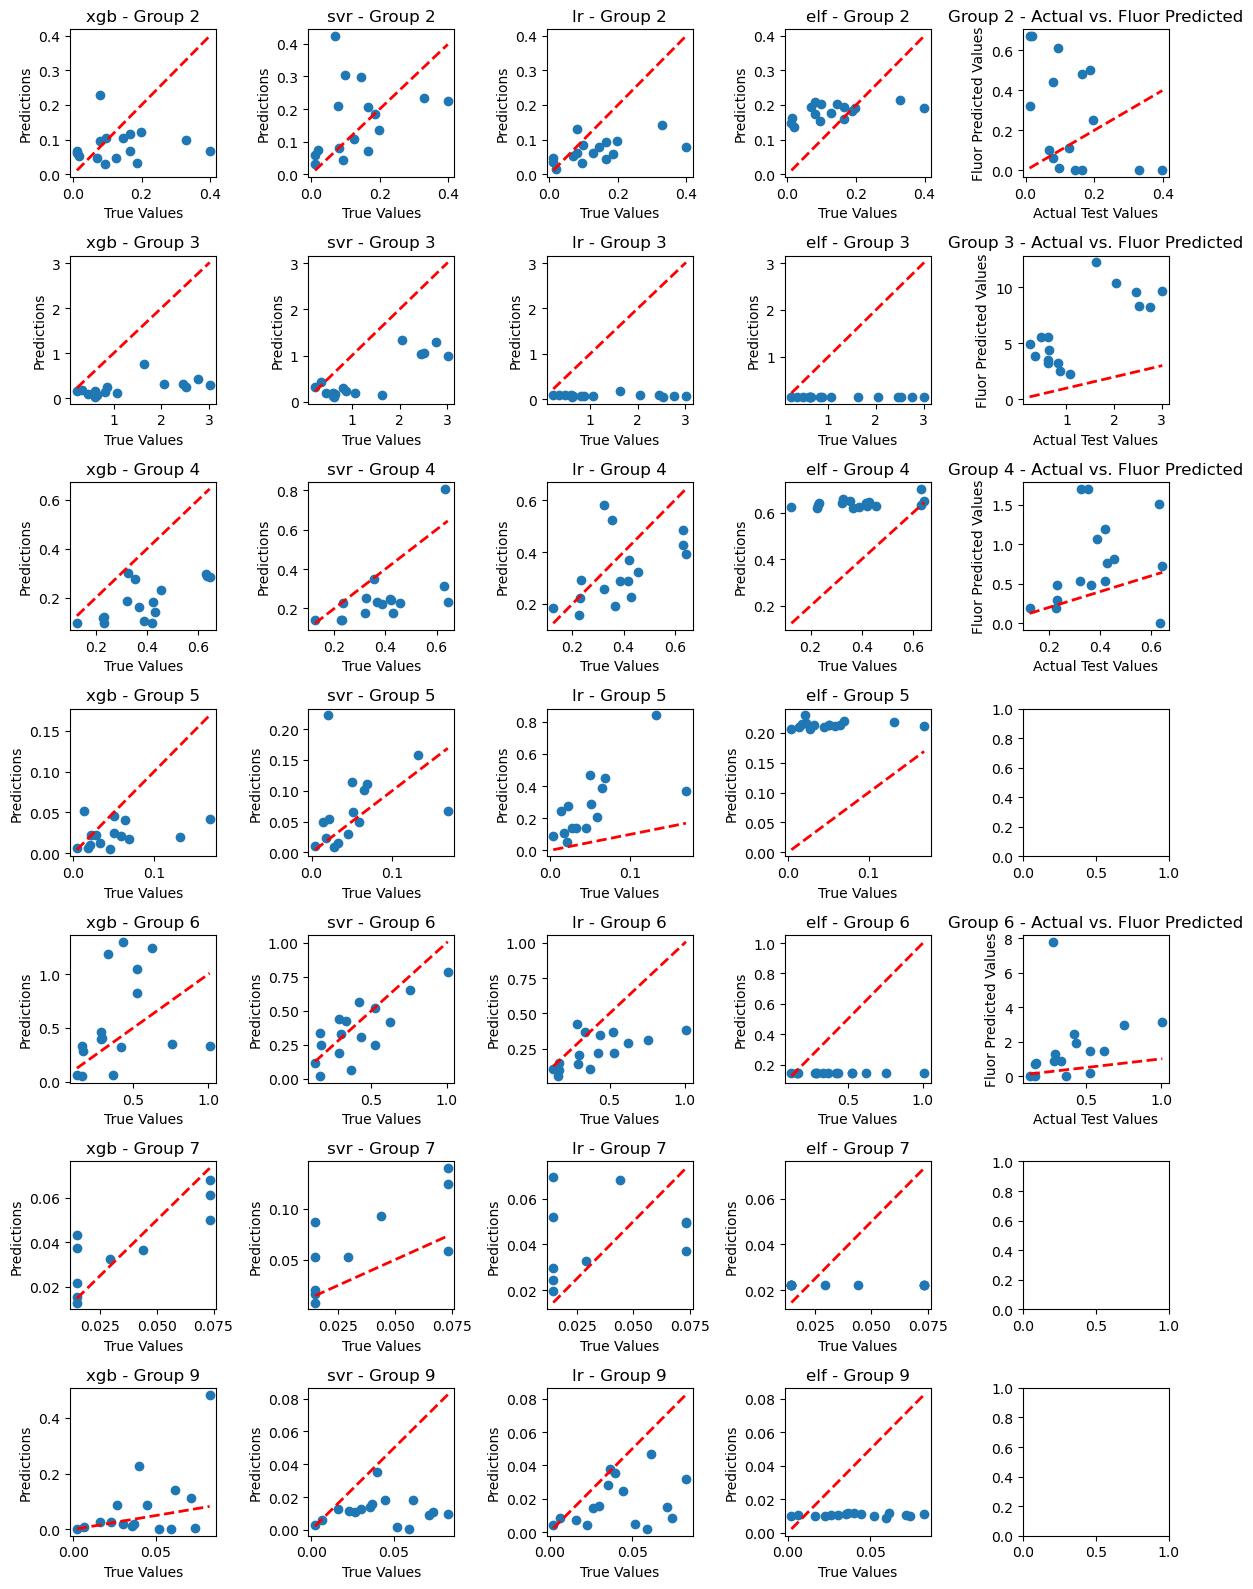

In [42]:
comparing_df_orig = compare_all_models(regression_models_orig, merged_val.drop(['year', 'Depth', 'week'], axis=1), fluor_val_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr', 'lr', 'elf'])

In [43]:
not_cleaned_res = compare_by_mpe(merged_val, regression_models_orig, predict_cols=merged_train.drop(['sum_biomass_ug_ml', 'group_num'], axis=1).columns, predict_fn=np.exp)

# With Outliers With Smogn

In [44]:
smogn_file = './data/with_outliers_smogn_merged_train_with_7_9.pkl'
do_smogn = not os.path.exists(smogn_file)

In [45]:
if do_smogn:
    orig_merged_train_smogn = []
    for group_num in orig_merged_train['group_num'].unique():
        group_df = orig_merged_train[orig_merged_train['group_num'] == group_num]
        print(f'********Group {group_num}************')
        print(group_df.shape)
        group_df_smogn = smogn.smoter(
            data = group_df.reset_index(drop=True),  ## pandas dataframe
            y = 'sum_biomass_ug_ml'  ## string ('header name')
        )
        print(group_df_smogn.shape)

        ## plot y distribution 
        plt.figure(figsize=(8, 6))
        seaborn.kdeplot(group_df['sum_biomass_ug_ml'], label = "Original")
        seaborn.kdeplot(group_df_smogn['sum_biomass_ug_ml'], label = "Modified")
        plt.legend()
        plt.show()

        orig_merged_train_smogn.append(group_df_smogn)


    orig_merged_train_smogn_concat = pd.concat(orig_merged_train_smogn, ignore_index=True)
    with open(smogn_file, 'wb') as f:
        pickle.dump(orig_merged_train_smogn_concat, f)
        
else:
    with open(smogn_file, 'rb') as f:
        orig_merged_train_smogn_concat = pickle.load(f)

In [46]:
regression_models_orig_smogn = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models_orig_smogn[model_name], _ = train(model_name, orig_merged_train_smogn_concat, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models_orig_smogn['lr'], _ = train('lr', orig_merged_train_smogn_concat, test_size=0.0, biomass_fn=np.log)

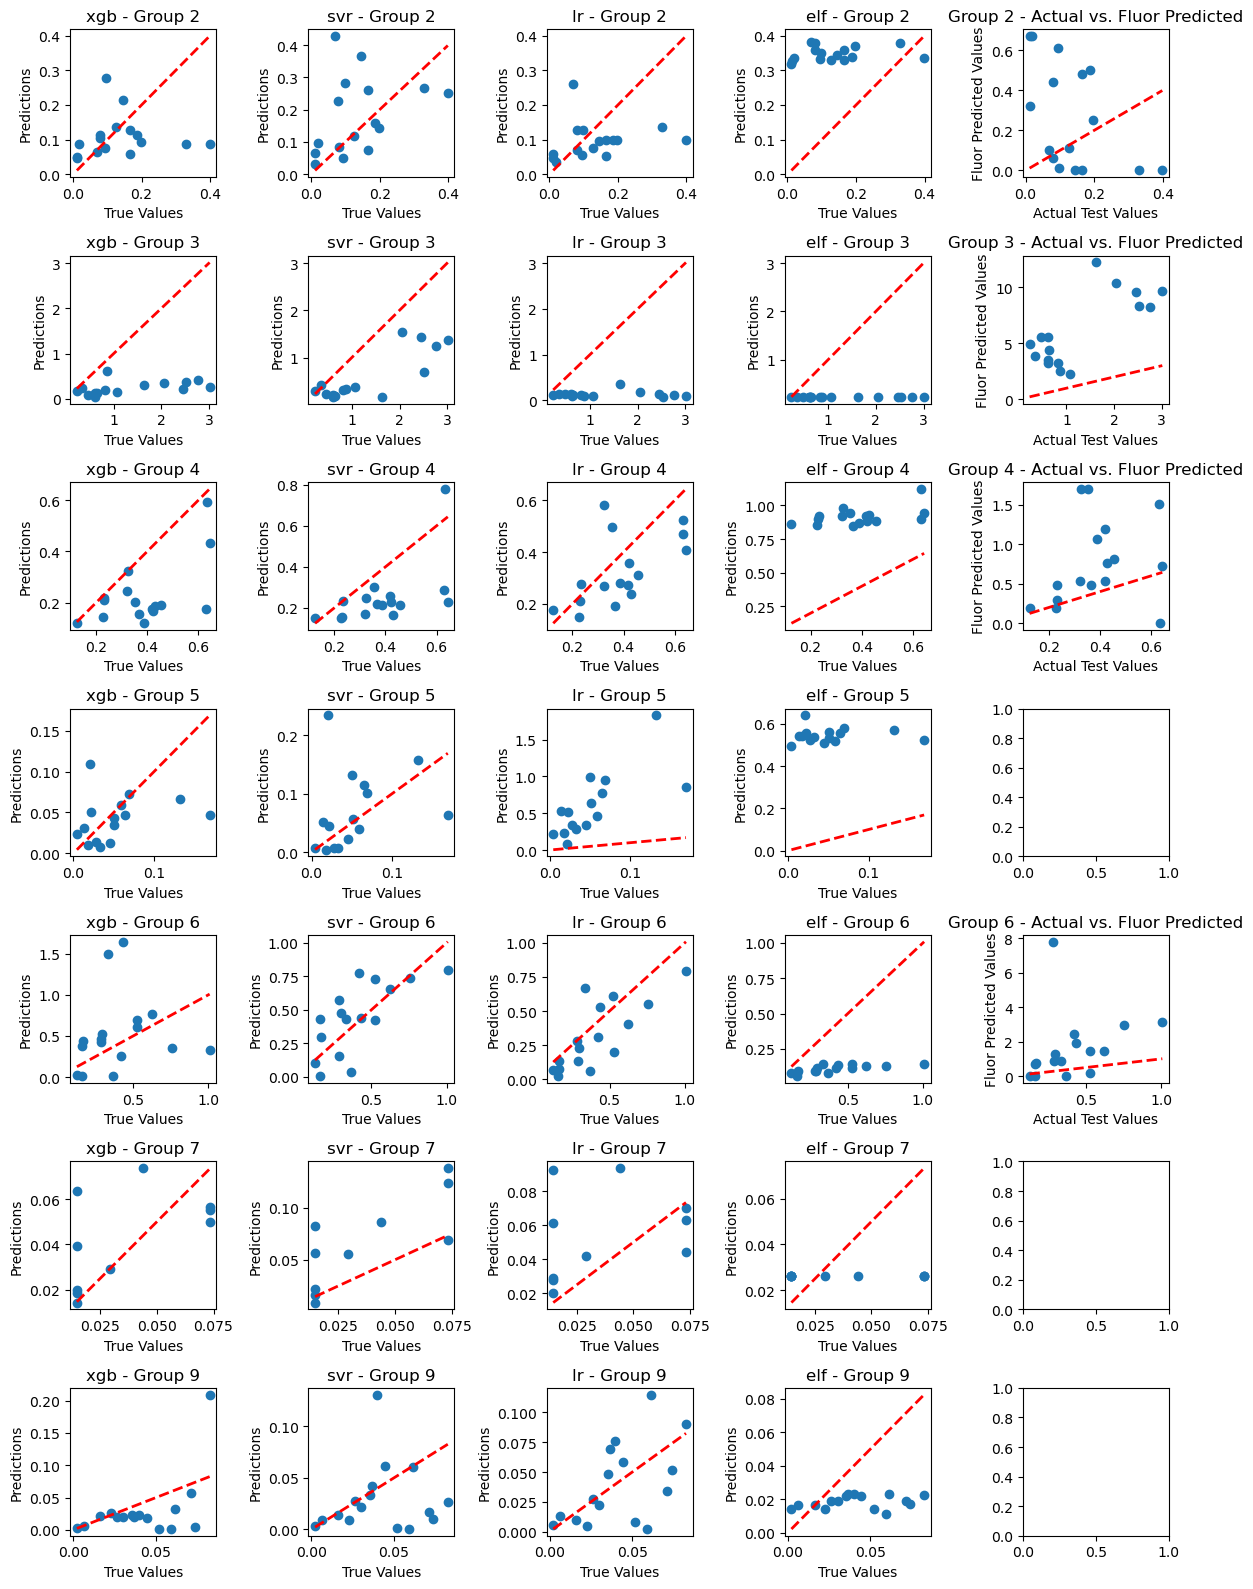

In [47]:
comparing_df_orig_smogn = compare_all_models(regression_models_orig_smogn, merged_val.drop(['year', 'Depth', 'week'], axis=1), fluor_val_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr', 'lr', 'elf'])

In [48]:
not_cleaned_smogn_res = compare_by_mpe(merged_val, regression_models_orig_smogn, predict_cols=merged_train.drop(['sum_biomass_ug_ml', 'group_num'], axis=1).columns, predict_fn=np.exp)

# Compare All Methods

In [49]:
fp_res['Source'] = 'FP'
cleaned_res['Source'] = 'Cleaned'
cleaned_smogn_res['Source'] = 'Cleaned SMOGN'
not_cleaned_res['Source'] = 'Not Cleaned'
not_cleaned_smogn_res['Source'] = 'Not Cleaned SMOGN'

all_results = pd.concat([fp_res, cleaned_res, cleaned_smogn_res, not_cleaned_res, not_cleaned_smogn_res])
all_results

Model          2          3          4          6             Source  \
0    FP   7.292489  16.520820  10.004369   8.992688                 FP   
0   xgb   6.249569  29.139533   7.979803  26.523973            Cleaned   
1   svr   5.479561  21.223450   5.952484  10.769572            Cleaned   
2   elf   7.746967  39.903757  29.668041   9.964420            Cleaned   
3    lr   3.813582  41.406103  16.199409   8.302129            Cleaned   
0   xgb   7.213849  26.215977   9.863516  14.820680      Cleaned SMOGN   
1   svr   6.128990  18.576855   7.889927  10.811494      Cleaned SMOGN   
2   elf   5.669708  41.108933  21.900491  11.823117      Cleaned SMOGN   
3    lr   4.611077  40.876316   7.049603   7.976129      Cleaned SMOGN   
0   xgb   5.869427  28.999929   7.087340  23.150536        Not Cleaned   
1   svr   5.583933  21.341393   6.059866  10.793047        Not Cleaned   
2   elf   7.540953  40.018091  30.039392   9.984641        Not Cleaned   
3    lr   3.822702  41.513250  16.031615   9.238392        Not Cleaned   
0   xgb   5.530988  28.576911  10.415604  21.150119  Not Cleaned SMOGN   
1   svr   5.718169  18.683753   5.994011  12.171287  Not Cleaned SMOGN   
2   elf  10.029373  40.343361  24.966324  14.199840  Not Cleaned SMOGN   
3    lr   5.501374  40.298625   9.651692   5.104982  Not Cleaned SMOGN   

           5         7         9  
0        NaN       NaN       NaN  
0   1.849711  0.833640  2.849091  
1   2.940893  1.421719  0.884160  
2  12.421167  0.780444  1.019985  
3  20.711306  1.435041  0.744241  
0   1.655168  0.943622  2.861571  
1   2.616402  0.852225  1.338862  
2  28.622508  0.740192  0.884037  
3  43.190862  1.098488  1.128975  
0   2.018832  0.942509  3.789780  
1   2.849441  1.529195  0.902789  
2  12.542396  0.782099  1.021248  
3  20.911558  1.483795  0.675012  
0   2.222151  0.802242  1.212917  
1   2.554803  1.145668  1.151871  
2  21.142772  0.727968  0.951585  
3  32.408748  1.276557  0.882375

# Custom SMOGN

In [50]:
k = 15
samp_method = 'extreme'
rel_thres = 0.9
rel_method = 'auto'
rel_xtrm_type = 'high'
rel_coef = 1.9

arg_name = f"with_7_9_k_{k}_samp_meth_{samp_method}_rel_thres_{''.join(str(rel_thres).split('.'))}_rel_meth_{rel_method}_rel_x_t_{rel_xtrm_type}_rel_coef_{''.join(str(rel_coef).split('.'))}"
smogn_file = f'./data/smogn_{arg_name}.pkl'
do_smogn = not os.path.exists(smogn_file)

In [51]:
if do_smogn:
    merged_train_smogn = []
    for group_num in merged_train['group_num'].unique():
        group_df = merged_train[merged_train['group_num'] == group_num]
        print(f'********Group {group_num}************')
        print(group_df.shape)
        group_df_smogn = smogn.smoter(
            data = group_df.reset_index(drop=True),  ## pandas dataframe
            y = 'sum_biomass_ug_ml',  ## string ('header name')
            k=k,
            samp_method=samp_method,
            rel_thres=rel_thres,
            rel_method=rel_method,
            rel_xtrm_type=rel_xtrm_type,
            rel_coef=rel_coef
        )
        print(group_df_smogn.shape)

        ## plot y distribution 
        plt.figure(figsize=(8, 6))
        seaborn.kdeplot(group_df['sum_biomass_ug_ml'], label = "Original")
        seaborn.kdeplot(group_df_smogn['sum_biomass_ug_ml'], label = "Modified")
        plt.legend()
        plt.show()

        merged_train_smogn.append(group_df_smogn)


    merged_train_smogn_concat = pd.concat(merged_train_smogn, ignore_index=True)
    with open(smogn_file, 'wb') as f:
        pickle.dump(merged_train_smogn_concat, f)
        
else:
    with open(smogn_file, 'rb') as f:
        merged_train_smogn_concat = pickle.load(f)

In [52]:
regression_models_custom_smogn = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models_custom_smogn[model_name], _ = train(model_name, merged_train_smogn_concat, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models_custom_smogn['lr'], _ = train('lr', merged_train_smogn_concat, test_size=0.0, biomass_fn=np.log)

# Results and Evaluations

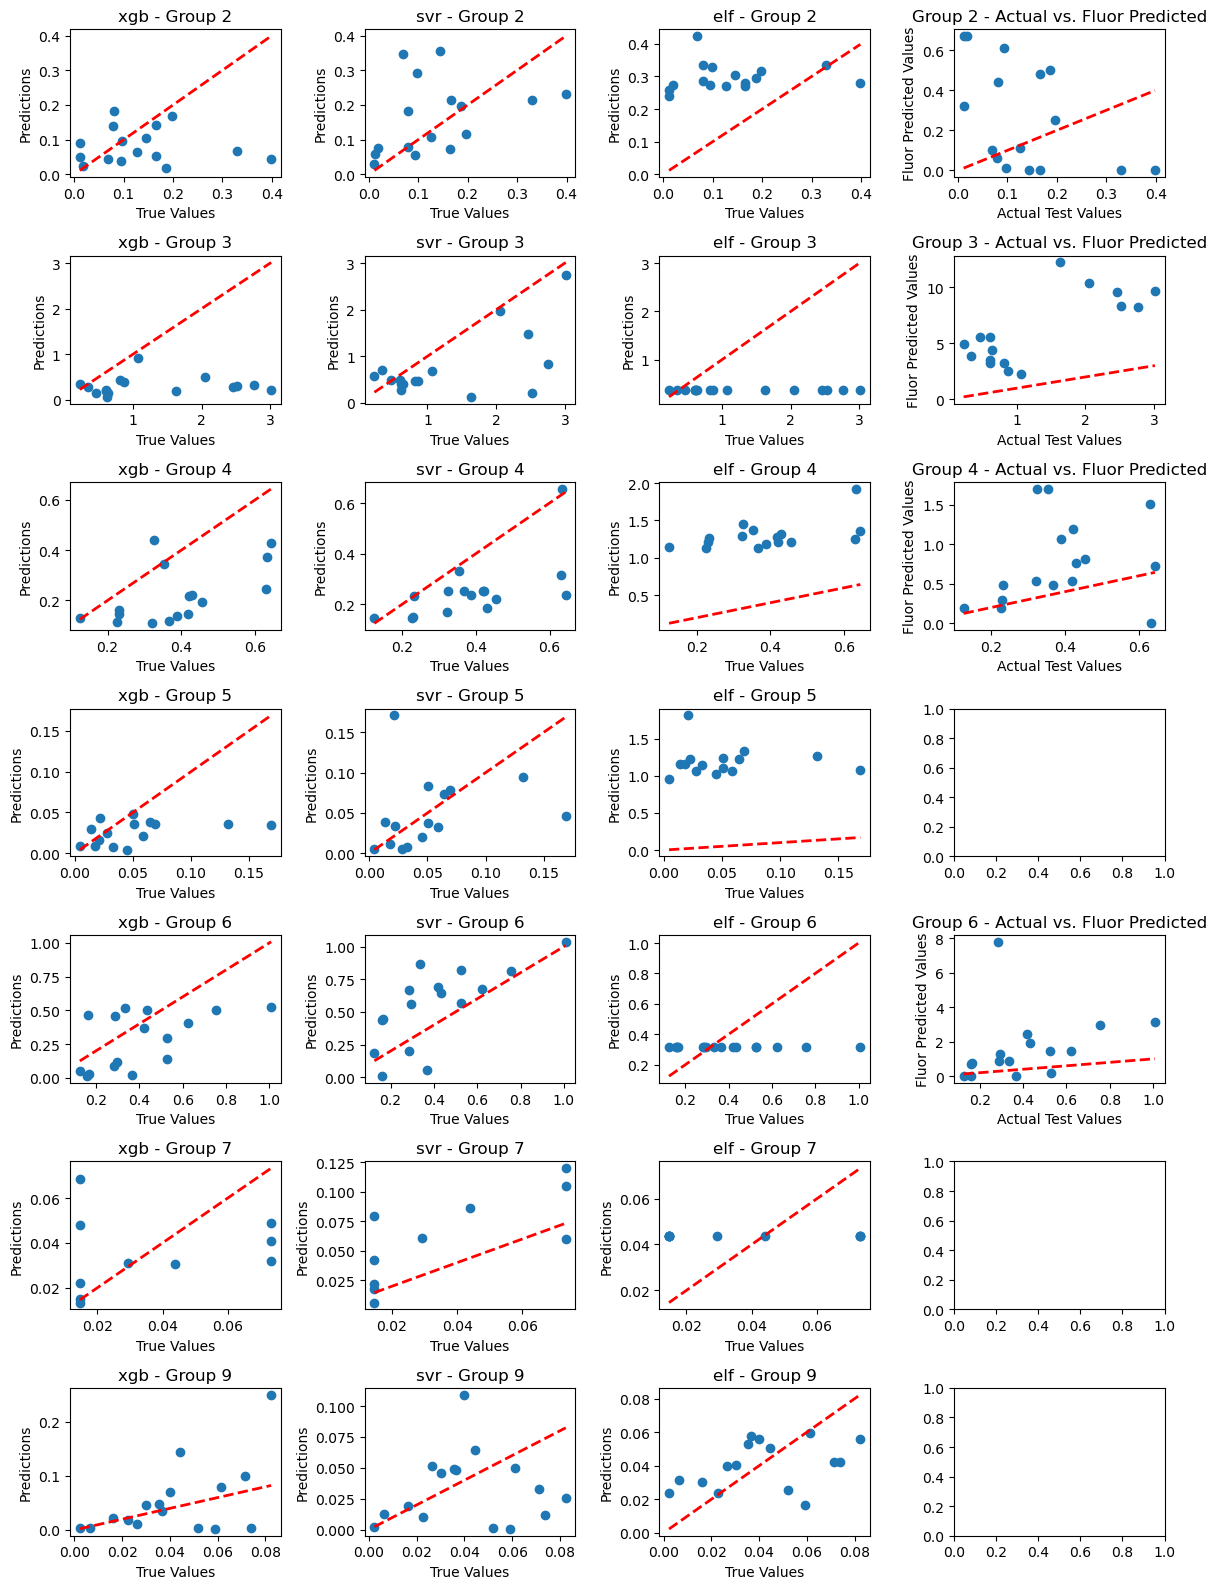

In [53]:
comparing_df_custom_smogn = compare_all_models(regression_models_custom_smogn, merged_val.drop(['year', 'Depth', 'week'], axis=1), fluor_val_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr', 'elf'])

In [54]:
cleaned_custom_smogn_res = compare_by_mpe(merged_val, regression_models_custom_smogn, predict_cols=merged_train.drop(['sum_biomass_ug_ml', 'group_num'], axis=1).columns, predict_fn=np.exp)

In [55]:
cleaned_custom_smogn_res['Source'] = 'Cleaned Custom SMOGN'

all_results = pd.concat([all_results, cleaned_custom_smogn_res])
all_results

Model          2          3          4          6                Source  \
0    FP   7.292489  16.520820  10.004369   8.992688                    FP   
0   xgb   6.249569  29.139533   7.979803  26.523973               Cleaned   
1   svr   5.479561  21.223450   5.952484  10.769572               Cleaned   
2   elf   7.746967  39.903757  29.668041   9.964420               Cleaned   
3    lr   3.813582  41.406103  16.199409   8.302129               Cleaned   
0   xgb   7.213849  26.215977   9.863516  14.820680         Cleaned SMOGN   
1   svr   6.128990  18.576855   7.889927  10.811494         Cleaned SMOGN   
2   elf   5.669708  41.108933  21.900491  11.823117         Cleaned SMOGN   
3    lr   4.611077  40.876316   7.049603   7.976129         Cleaned SMOGN   
0   xgb   5.869427  28.999929   7.087340  23.150536           Not Cleaned   
1   svr   5.583933  21.341393   6.059866  10.793047           Not Cleaned   
2   elf   7.540953  40.018091  30.039392   9.984641           Not Cleaned   
3    lr   3.822702  41.513250  16.031615   9.238392           Not Cleaned   
0   xgb   5.530988  28.576911  10.415604  21.150119     Not Cleaned SMOGN   
1   svr   5.718169  18.683753   5.994011  12.171287     Not Cleaned SMOGN   
2   elf  10.029373  40.343361  24.966324  14.199840     Not Cleaned SMOGN   
3    lr   5.501374  40.298625   9.651692   5.104982     Not Cleaned SMOGN   
0   xgb   5.730536  22.972275  10.005697  10.875489  Cleaned Custom SMOGN   
1   svr   5.368620  16.855679   7.932766  11.319432  Cleaned Custom SMOGN   
2   elf   5.220084  40.047650  19.779457  10.771546  Cleaned Custom SMOGN   
3    lr   4.552228  37.484072   7.476128   6.829900  Cleaned Custom SMOGN   

           5         7         9  
0        NaN       NaN       NaN  
0   1.849711  0.833640  2.849091  
1   2.940893  1.421719  0.884160  
2  12.421167  0.780444  1.019985  
3  20.711306  1.435041  0.744241  
0   1.655168  0.943622  2.861571  
1   2.616402  0.852225  1.338862  
2  28.622508  0.740192  0.884037  
3  43.190862  1.098488  1.128975  
0   2.018832  0.942509  3.789780  
1   2.849441  1.529195  0.902789  
2  12.542396  0.782099  1.021248  
3  20.911558  1.483795  0.675012  
0   2.222151  0.802242  1.212917  
1   2.554803  1.145668  1.151871  
2  21.142772  0.727968  0.951585  
3  32.408748  1.276557  0.882375  
0   1.475566  1.041939  3.185293  
1   1.981114  0.643014  1.100303  
2  28.964375  0.739906  0.689098  
3  38.688073  1.119109  2.218235

In [57]:
def bar_plot_per_model_by_sources(df, model_name):
    # Filter the DataFrame for the selected 'Model'
    model_data = pd.concat([df[df['Model'] == model_name], df[df['Model'] == 'FP']])
    model_data = model_data[model_data['Source'].isin(['Cleaned', 'Cleaned Custom SMOGN', 'FP'])]
    model_data.loc[model_data['Source'] == 'Cleaned', 'Source'] = 'Without SMOGN'
    model_data.loc[model_data['Source'] == 'Cleaned Custom SMOGN', 'Source'] = 'With SMOGN'
    model_data.loc[model_data['Source'] == 'FP', 'Source'] = 'FP'
    # Columns to be plotted
    columns_to_plot = [2, 3, 4, 5, 6, 7, 9]

    # Group the data by the 'Source' column and calculate the mean for each column
    grouped_data = model_data.groupby('Source')[columns_to_plot].mean()

    # Transpose the grouped data for easier plotting
    grouped_data = grouped_data.transpose()

    # Plot the multi-group bar chart
    ax = grouped_data.plot(kind='bar', figsize=(10, 6))
    plt.xlabel('Groups')
    plt.ylabel('Mean Percentage Error (%)')
    plt.title(f'Multi-Group Bar Plot for Model: {model_name}')
    plt.legend(title='Source', loc='upper right')
    plt.xticks(range(len(columns_to_plot)), columns_to_plot)
    plt.show()

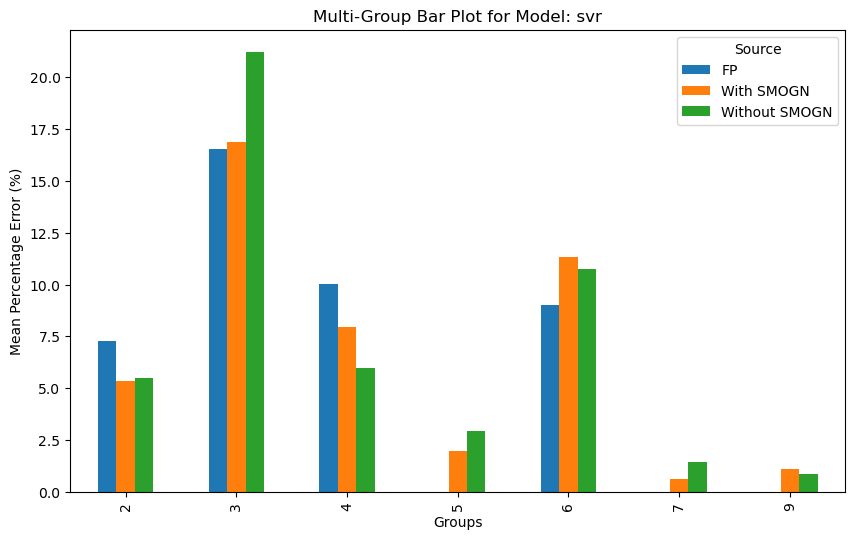

In [58]:
bar_plot_per_model_by_sources(all_results, 'svr')

In [122]:
def bar_plot_all_models_smogn(df):
    # Filter the DataFrame to include only the desired columns and models
    selected_columns = [2, 3, 4, 5, 6, 7, 9]
    selected_models = ['xgb', 'svr', 'elf', 'FP']
    selected_sources = ['FP', 'Cleaned Custom SMOGN']
    filtered_df = df[(df['Model'].isin(selected_models)) & 
                              (df['Source'].isin(selected_sources))]

    # Set up the figure and axis for plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Width of each bar
    bar_width = 0.15
    index = np.arange(len(selected_columns))

    # Iterate through each model and create a grouped bar plot
    for i, model in enumerate(selected_models):
        model_data = filtered_df[filtered_df['Model'] == model]
        y = model_data[selected_columns].values[0]  # Corresponding values for the model
        ax.bar(index + i * bar_width, y, bar_width, label=model)

    # Set labels and title
    ax.set_xlabel('Columns')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of MPE for Different Models')
    ax.set_xticks(index + bar_width * (len(selected_models) - 1) / 2)
    ax.set_xticklabels(selected_columns)
    ax.legend()

    # Show the plot
    plt.show()

### Framework for Comparing Fluor-Probe's Predictions  with Real Phytoplankton Biomass

#### Step 1: Aggregation of Real Biomass Data

For each unique combination of 'week,' 'year,' 'month,' and 'depth,' we calculate the total biomass by summing the biomasses of all the different phytoplankton groups within that combination. 

Let $B_{i}$ represent the biomass of group $i$ within a specific combination, and $B_{total}$ be the total biomass within that combination. The percentage of biomass for group $i$: $b_{i}$, is calculated as:

$\text{Percentage Biomass for Group } i = b_{i} = \frac{B_{i}}{B_{\text{total}}} \times 100$

#### Step 2: Regression Model

We employ a regression model to predict the biomass of each phytoplankton group based on the given attributes ('week,' 'year,' 'month,' and 'depth').

#### Step 3: Aggregation of Predicted Biomass Data

For each unique combination of 'week,' 'year,' 'month,' and 'depth,' we calculate the total predicted biomass by summing the predicted biomasses of all the different phytoplankton groups within that combination. 

Let $P_{i}$ represent the predicted biomass of group $i$ within a specific combination, and $P_{\text{total}}$ be the total predicted biomass within that combination. The percentage of predicted biomass for group $i$: p_{i}, is calculated as:


$\text{Percentage Predicted Biomass for Group } i = p_{i} = \frac{P_{i}}{P_{\text{total}}} \times 100$

<div style="height: 200px;"></div>

#### Step 4: Calculation of Mean Proportion Error (MPE)

The Mean Proportion Error (MPE) for each phytoplankton group is calculated as the average difference between the real percentage biomass and the predicted percentage biomass across all combinations of 'week,' 'year,' 'month,' and 'depth':

$
\text{MPE for Group } i = \frac{1}{N} \sum_{j=1}^{N} \left| b_{i} - p_{i}\right|
$

Where:
- $N$ is the total number of unique combinations of 'week,' 'year,' 'month,' and 'depth' in the dataset.
- The absolute difference between the real and predicted percentages is used to account for both overestimations and underestimations.

For the total MPE we can sum $\forall{i} \ \ MPE_{i}$ and divide by the  number of groups, $n$:

$\text{Total MPE} = \frac{1}{n} \sum_{j=1}^{n} \left| MPE_{i}\right|$

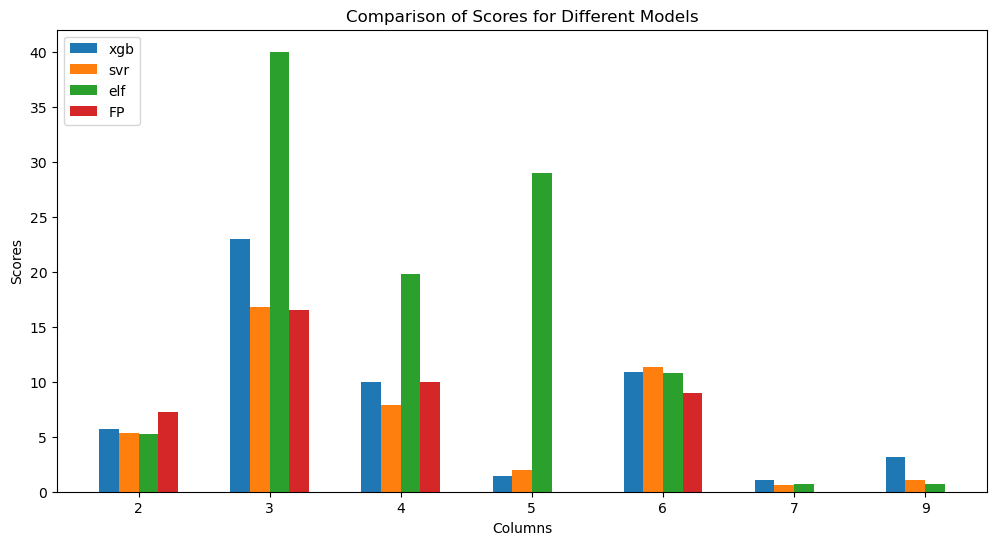

In [123]:
bar_plot_all_models_smogn(all_results)

In [70]:
comparing_df['Source'] = 'Cleaned'
comparing_df_smogn['Source'] = 'Cleaned SMOGN'
comparing_df_orig['Source'] = 'Not Cleaned'
comparing_df_orig_smogn['Source'] = 'Not Cleaned SMOGN'
comparing_df_custom_smogn['Source'] = 'Cleaned Custom SMOGN'
mse_all_results = pd.concat([comparing_df, comparing_df_smogn, comparing_df_orig, comparing_df_orig_smogn, comparing_df_custom_smogn])
mse_all_results

Group Model      RMSE  R-squared      MAPE                Source
0       2   xgb  0.124060  -0.422329  1.140761               Cleaned
1       2   svr  0.130028  -0.562468  1.276004               Cleaned
2       2    lr  0.112348  -0.166445  0.710408               Cleaned
3       2   elf  0.107225  -0.062488  2.439440               Cleaned
4       2    FP  0.342200  -9.821716  8.618267               Cleaned
..    ...   ...       ...        ...       ...                   ...
20      7   svr  0.033529  -0.715807  1.089937  Cleaned Custom SMOGN
21      7   elf  0.026530  -0.074203  1.158917  Cleaned Custom SMOGN
22      9   xgb  0.056753  -4.986455  0.713380  Cleaned Custom SMOGN
23      9   svr  0.036505  -1.476825  0.646758  Cleaned Custom SMOGN
24      9   elf  0.021949   0.104590  1.205289  Cleaned Custom SMOGN

[153 rows x 6 columns]

In [71]:
mse_all_results.loc[mse_all_results['Model'] == 'FP', 'Source'] = 'FP'

In [84]:
mse_all_results[mse_all_results['Source'] == 'FP'].drop_duplicates('Group')

Group Model      RMSE  R-squared      MAPE Source
4       2    FP  0.342200  -9.821716  8.618267     FP
9       3    FP  5.380280 -32.921282  5.666473     FP
14      4    FP  0.627456 -17.148938  1.180050     FP
23      6    FP  2.182008 -86.922911  3.786796     FP

In [92]:
mse_all_results_custom_smogn = mse_all_results[mse_all_results['Source'].isin(['FP', 'Cleaned Custom SMOGN'])].drop_duplicates(['Group', 'Model']).drop(columns=['R-squared', 'MAPE', 'Source']).pivot(index='Model', columns='Group')
mse_all_results_custom_smogn

RMSE                                                            
Group         2         3         4         5         6         7         9
Model                                                                      
FP     0.342200  5.380280  0.627456       NaN  2.182008       NaN       NaN
elf    0.194698  1.304881  0.925023  1.154923  0.248099  0.026530  0.021949
svr    0.121592  0.909528  0.179055  0.053820  0.249354  0.033529  0.036505
xgb    0.129236  1.347660  0.208340  0.047587  0.243319  0.027566  0.056753

In [120]:
t = mse_all_results_custom_smogn['RMSE'].reset_index()
t.columns.name = None
t

Model         2         3         4         5         6         7         9
0    FP  0.342200  5.380280  0.627456       NaN  2.182008       NaN       NaN
1   elf  0.194698  1.304881  0.925023  1.154923  0.248099  0.026530  0.021949
2   svr  0.121592  0.909528  0.179055  0.053820  0.249354  0.033529  0.036505
3   xgb  0.129236  1.347660  0.208340  0.047587  0.243319  0.027566  0.056753

In [127]:
def bar_plot_mse_all_models_smogn(df):
    # Filter the DataFrame to include only the desired columns and models
    selected_columns = [2, 3, 4, 5, 6, 7, 9]
    selected_models = ['xgb', 'svr', 'elf', 'FP']
    filtered_df = df.copy()

    # Set up the figure and axis for plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Width of each bar
    bar_width = 0.15
    index = np.arange(len(selected_columns))

    # Iterate through each model and create a grouped bar plot
    for i, model in enumerate(selected_models):
        model_data = filtered_df[filtered_df['Model'] == model]
        y = model_data[selected_columns].values[0]  # Corresponding values for the model
        ax.bar(index + i * bar_width, y, bar_width, label=model)

    # Set labels and title
    ax.set_xlabel('Columns')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of MSE for Different Models')
    ax.set_xticks(index + bar_width * (len(selected_models) - 1) / 2)
    ax.set_xticklabels(selected_columns)
    ax.legend()

    # Show the plot
    plt.show()

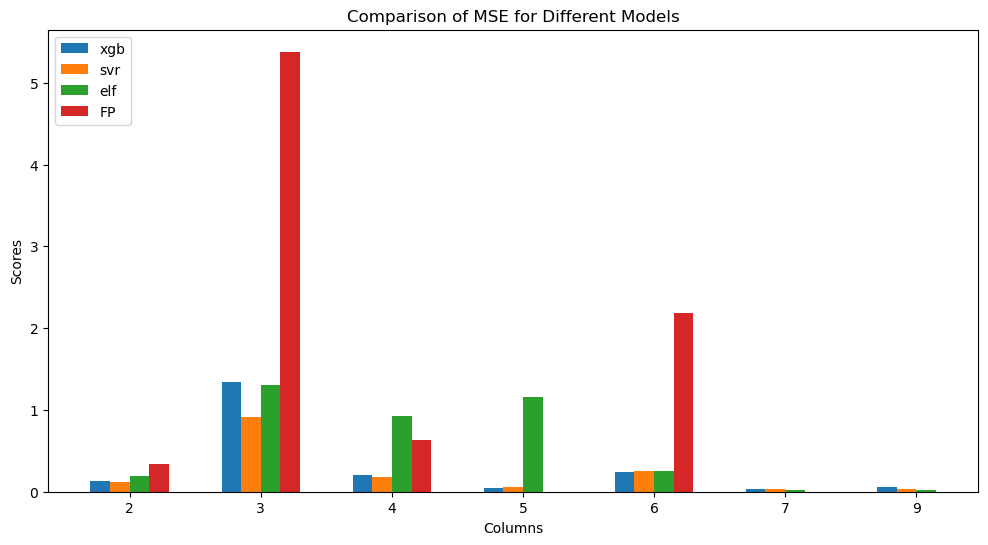

In [128]:
bar_plot_mse_all_models_smogn(t)

In [60]:
def bar_plot_mse_by_source_per_model(model_name, with_fp=True):
    # Filter the DataFrame for the selected 'Model'
    model_data = mse_all_results[mse_all_results['Model'] == model_name]
    if with_fp:
        model_data = pd.concat([mse_all_results[mse_all_results['Model'] == model_name], mse_all_results[mse_all_results['Model'] == 'FP'].drop_duplicates()])

    # Group the data by 'Group' and 'Source' columns and calculate the mean RMSE value for each group
    grouped_data = model_data.groupby(['Group', 'Source'])['RMSE'].mean().unstack()

    # Plot the bar chart for each 'Group'
    grouped_data.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.xlabel('Group')
    plt.ylabel('MSE')
    plt.title(f'MSE by Source for Model: {model_name}')
    plt.legend(title='Source', loc='upper right')
    plt.xticks(rotation=45)
    plt.show()

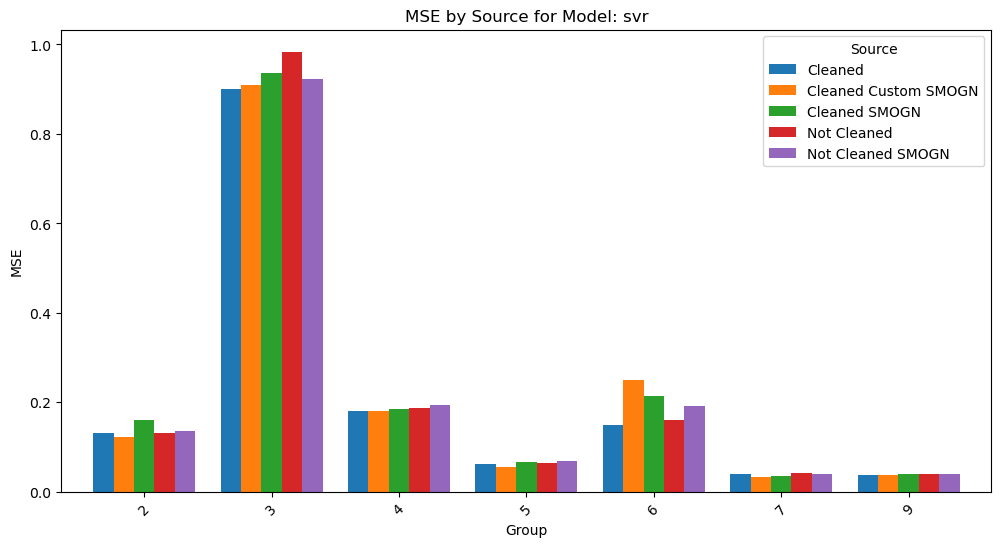

In [61]:
bar_plot_mse_by_source_per_model('svr', with_fp=False)

In [62]:
test_custom_smogn_mpe = compare_by_mpe(merged_test, regression_models_custom_smogn, predict_cols=merged_train.drop(['sum_biomass_ug_ml', 'group_num'], axis=1).columns, predict_fn=np.exp)
test_custom_smogn_mpe['Source'] = 'Cleaned Custom SMOGN'
test_fp_mpe = calc_mpe_fp(fluor_test_df, with_group_5=False)
test_fp_mpe['Source'] = 'FP'
test_mpe_res = pd.concat([test_custom_smogn_mpe, test_fp_mpe])

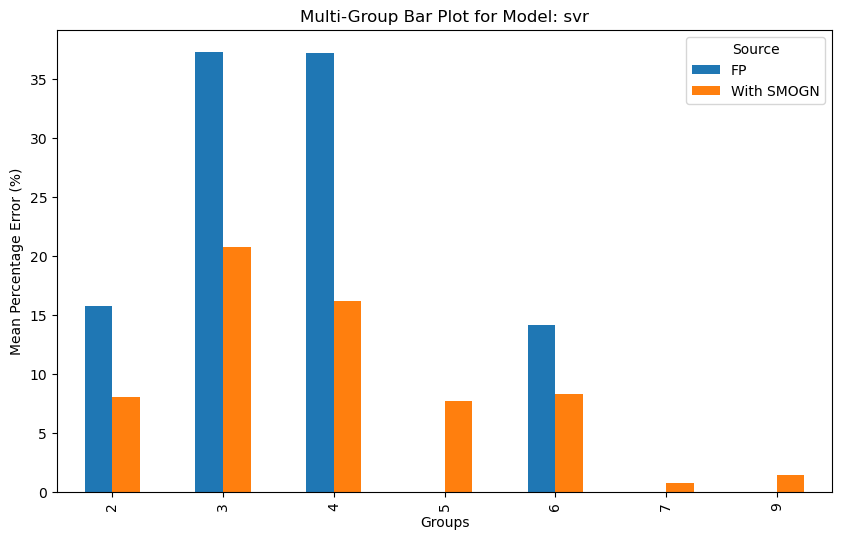

In [63]:
bar_plot_per_model_by_sources(test_mpe_res, 'svr')

Permutation explainer: 10392it [13:28, 12.75it/s]                               
Permutation explainer: 10756it [13:35, 13.00it/s]                               
Permutation explainer: 10956it [12:53, 13.97it/s]                               
Permutation explainer: 9688it [11:26, 13.89it/s]                                
Permutation explainer: 10581it [12:19, 14.11it/s]                               
Permutation explainer: 9510it [11:10, 13.95it/s]                                
Permutation explainer: 2766it [03:15, 13.34it/s]                                


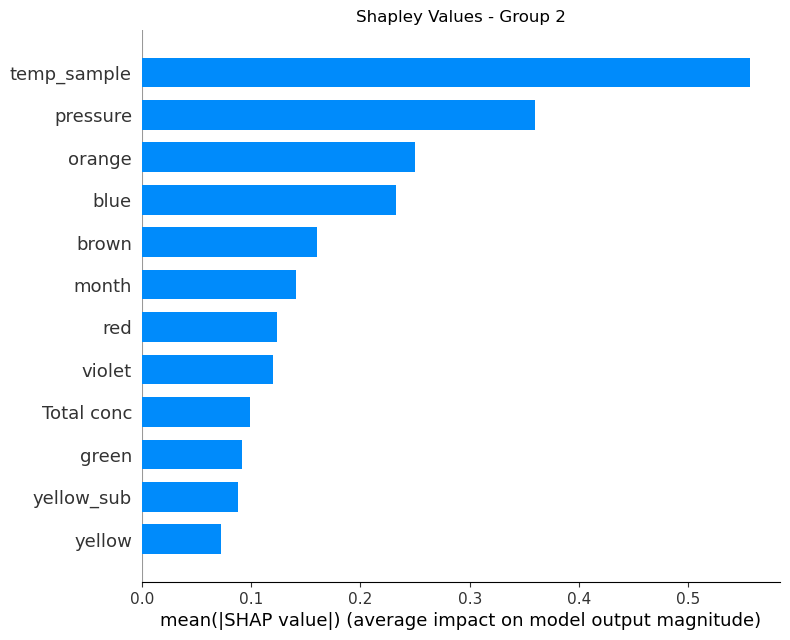

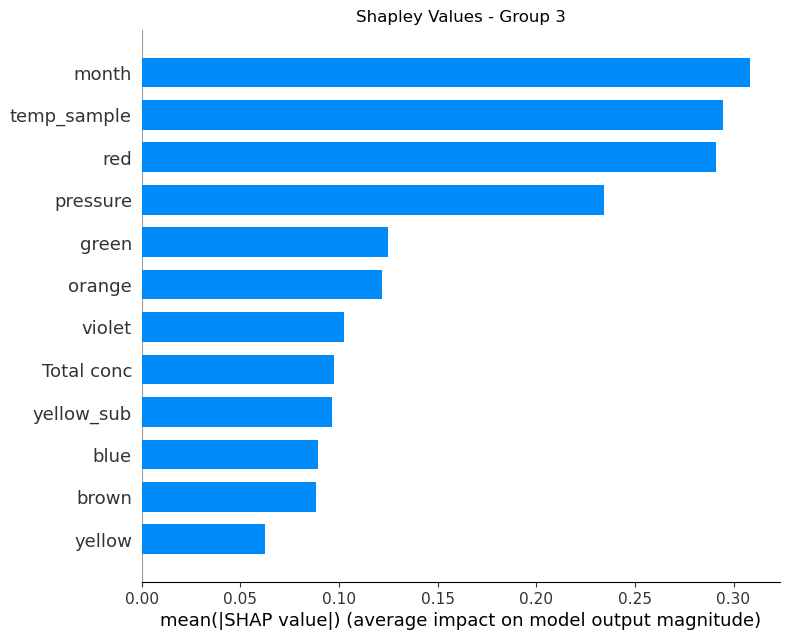

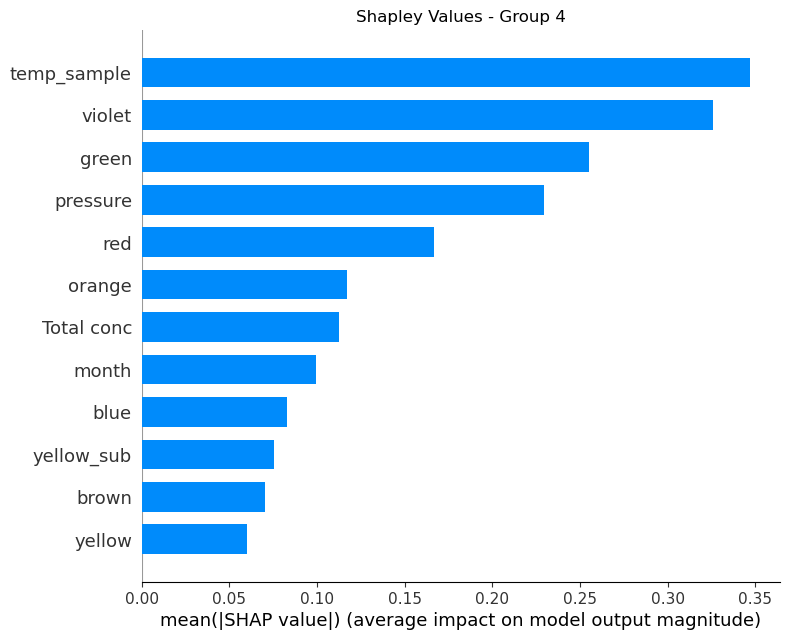

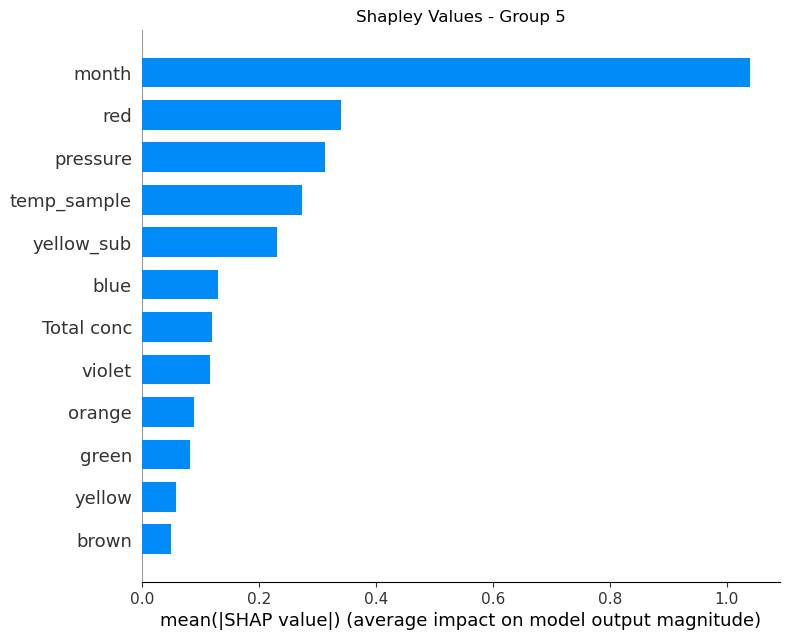

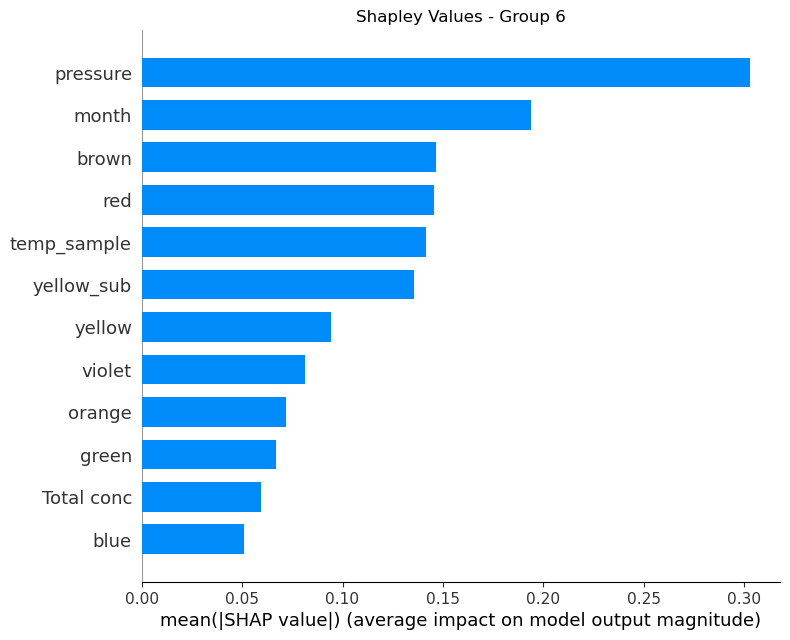

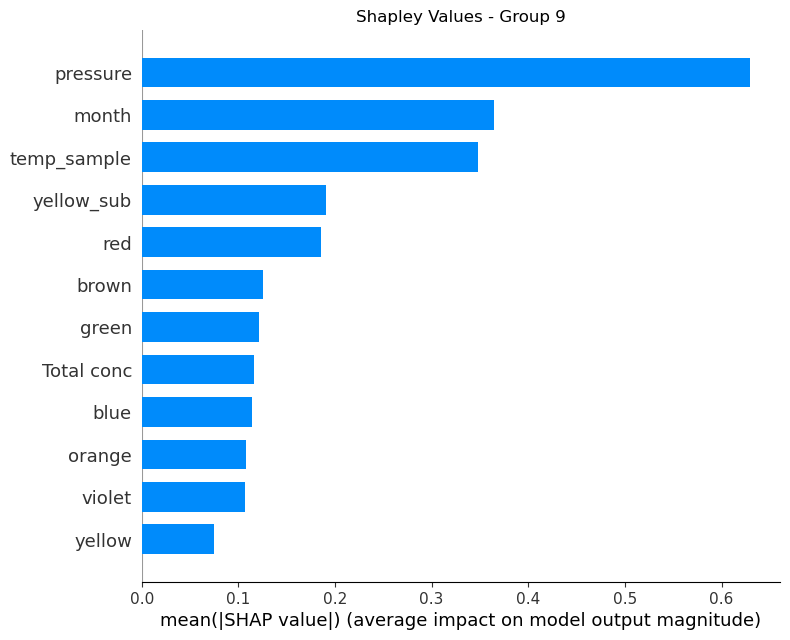

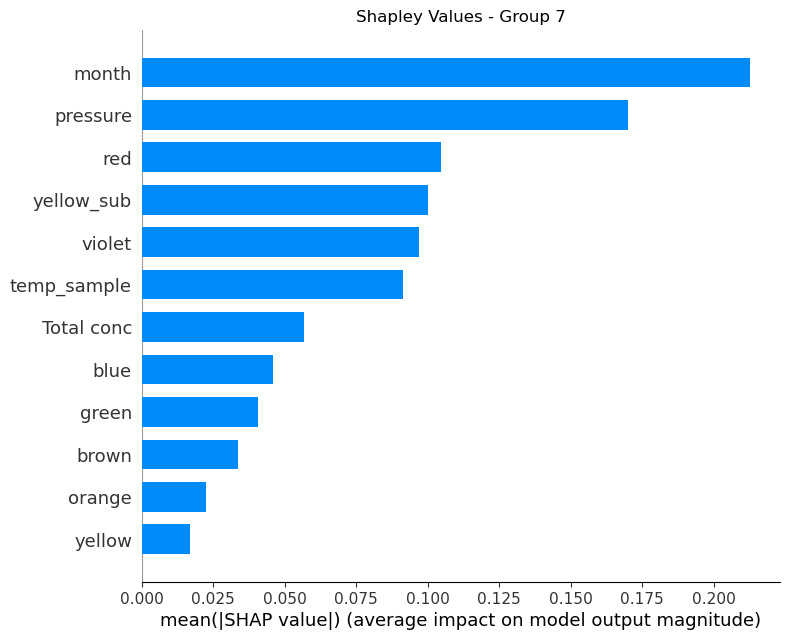

In [64]:
# shap_values_list_xgboost = plot_shap_values(merged_train, regression_models_custom_smogn['xgb'], merged_val.drop(['Depth', 'week', 'year'], axis=1))

Permutation explainer: 151it [56:16, 22.51s/it]                                 
Permutation explainer: 151it [1:00:20, 24.14s/it]                               
Permutation explainer: 151it [48:33, 19.42s/it]                                 
Permutation explainer: 151it [54:50, 21.94s/it]                                 
Permutation explainer: 151it [55:23, 22.16s/it]                                 
Permutation explainer: 151it [59:16, 23.71s/it]                                 
Permutation explainer: 151it [11:29,  4.66s/it]                                 


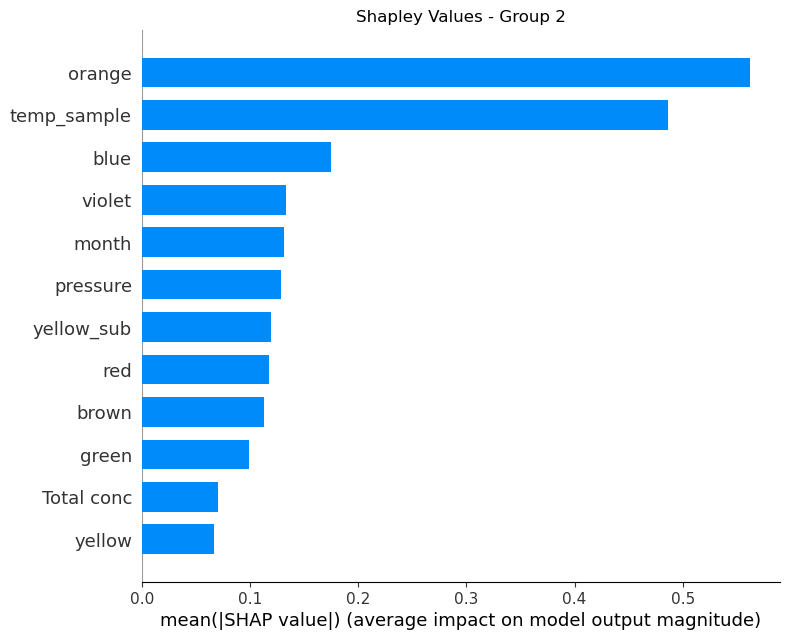

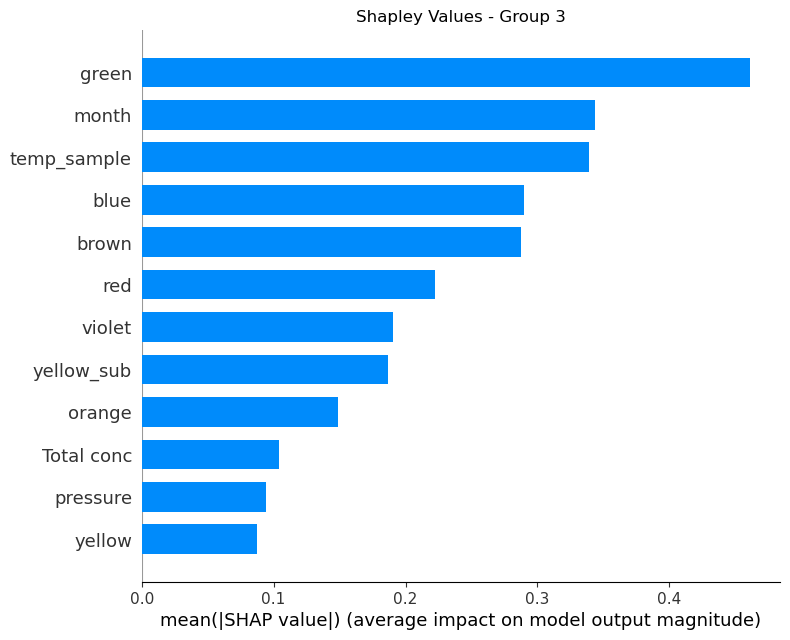

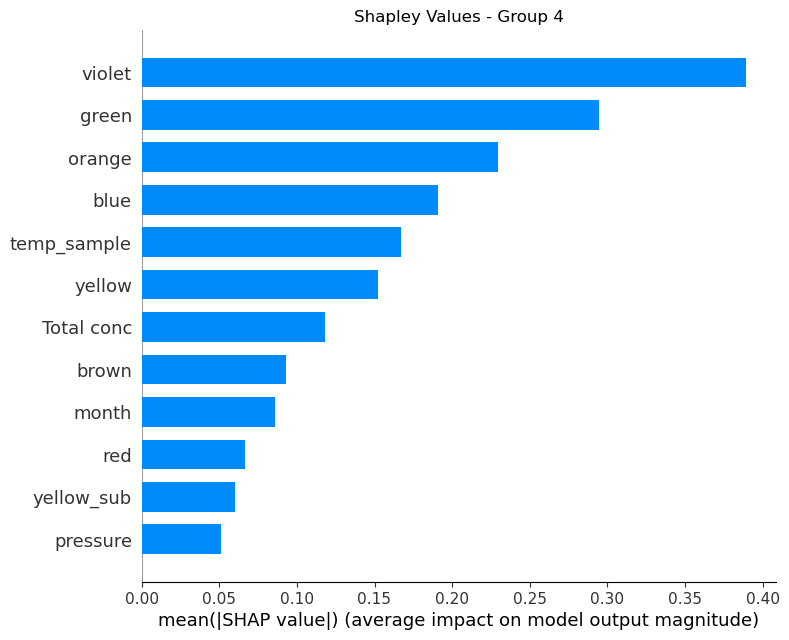

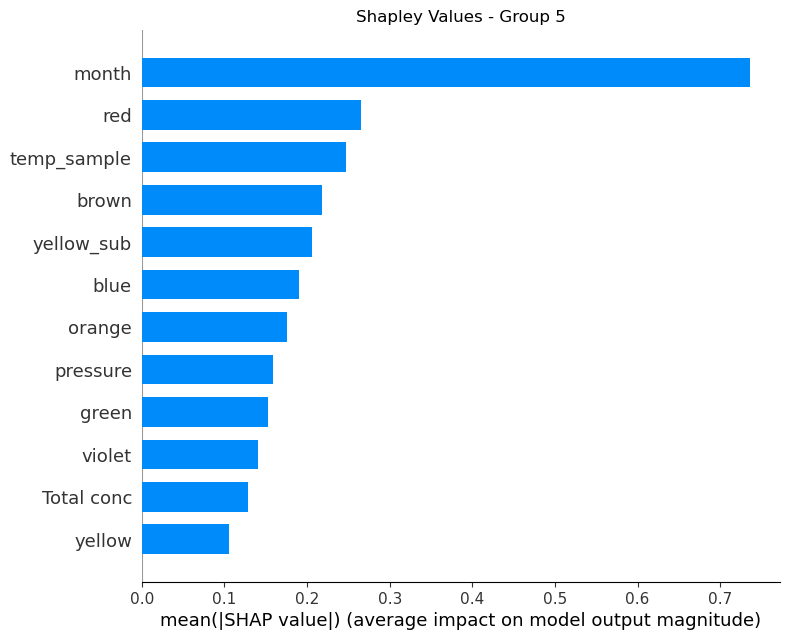

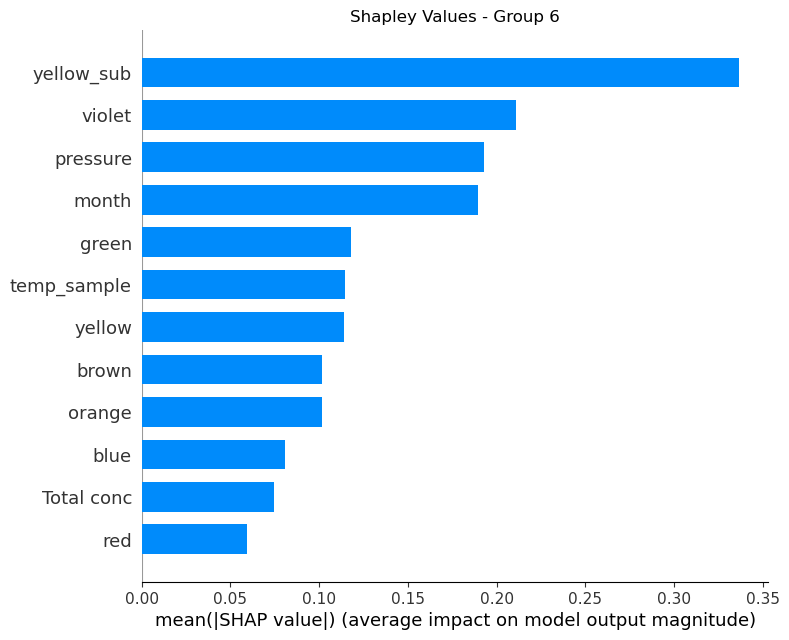

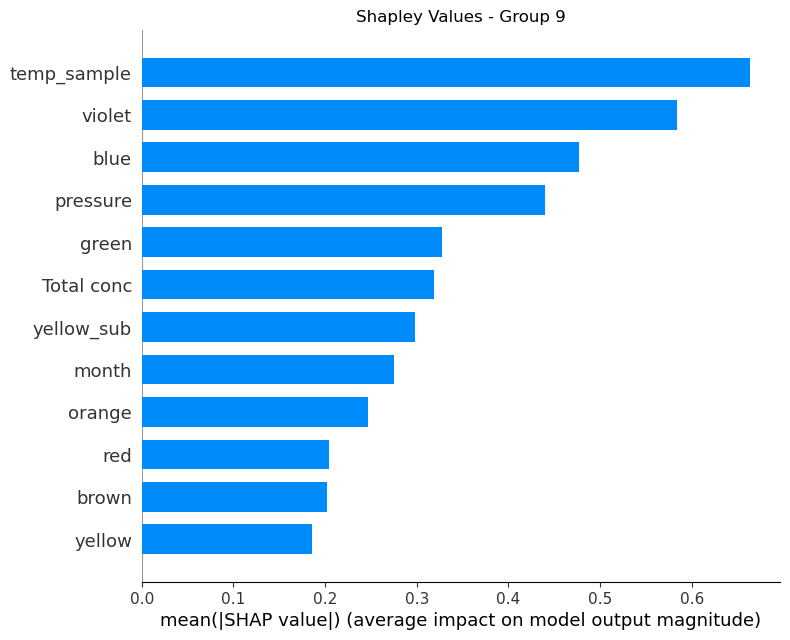

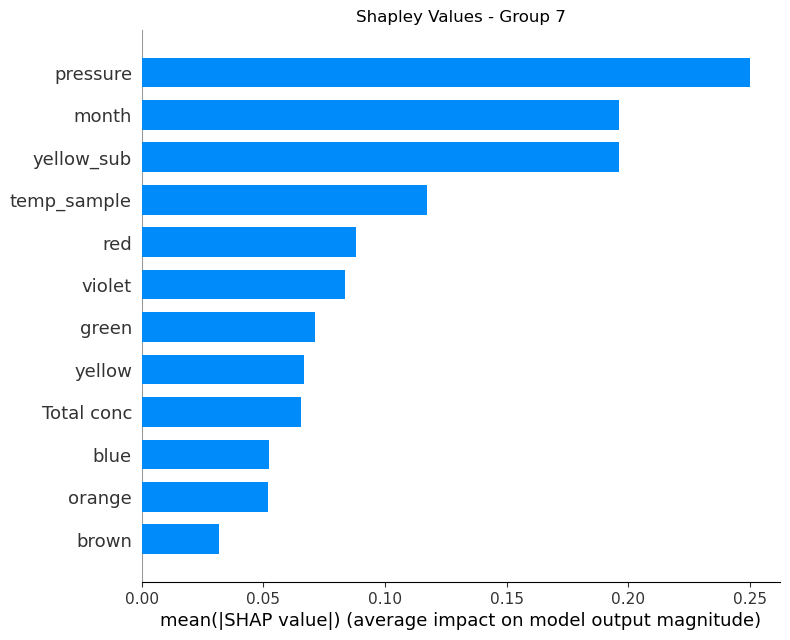

In [65]:
# shap_values_list_svr = plot_shap_values(merged_train_smogn_concat, regression_models_custom_smogn['svr'], merged_val.drop(['Depth', 'week', 'year'], axis=1), do_sample=True)

In [66]:
# with open('data/shap_values_list_xgboost.pkl', 'wb') as f:
#     pickle.dump(shap_values_list_xgboost, f)
    
# with open('data/shap_values_list_svr.pkl', 'wb') as f:
#     pickle.dump(shap_values_list_svr, f)

In [61]:
with open('data/shap_values_list_xgboost.pkl', 'rb') as f:
    shap_values_list_xgboost = pickle.load(f)
    
with open('data/shap_values_list_svr.pkl', 'rb') as f:
    shap_values_list_svr = pickle.load(f)

In [62]:
def shap_heatmap(shap_values_by_group, do_abs=True, model='SVR'):
    features_list = merged_val.drop(['group_num', 'sum_biomass_ug_ml', 'week', 'year', 'Depth'], axis=1).columns.tolist()

    # Create a DataFrame from the Shapley values
    shap_df = pd.DataFrame({k: np.average(np.abs(v.values) if do_abs else v.values, axis=0)
                            for k, v in shap_values_by_group.items()}, index=features_list)

    scaler = MinMaxScaler()
    scaled_shap_df = pd.DataFrame(scaler.fit_transform(shap_df), columns=shap_df.columns, index=shap_df.index)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(scaled_shap_df.transpose(), cmap='coolwarm', annot=True, fmt=".2f")
    plt.title(f"Shapley Values Heatmap - {model}")
    plt.xlabel("Features")
    plt.ylabel("Group Number")
    plt.show()


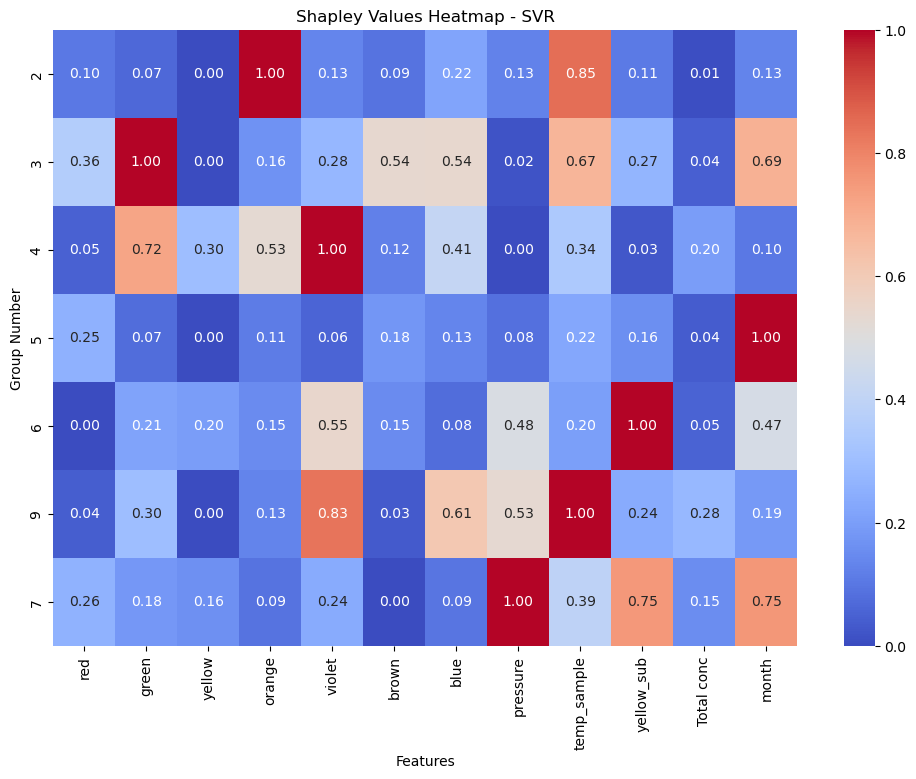

In [63]:
shap_heatmap(shap_values_list_svr, do_abs=True)

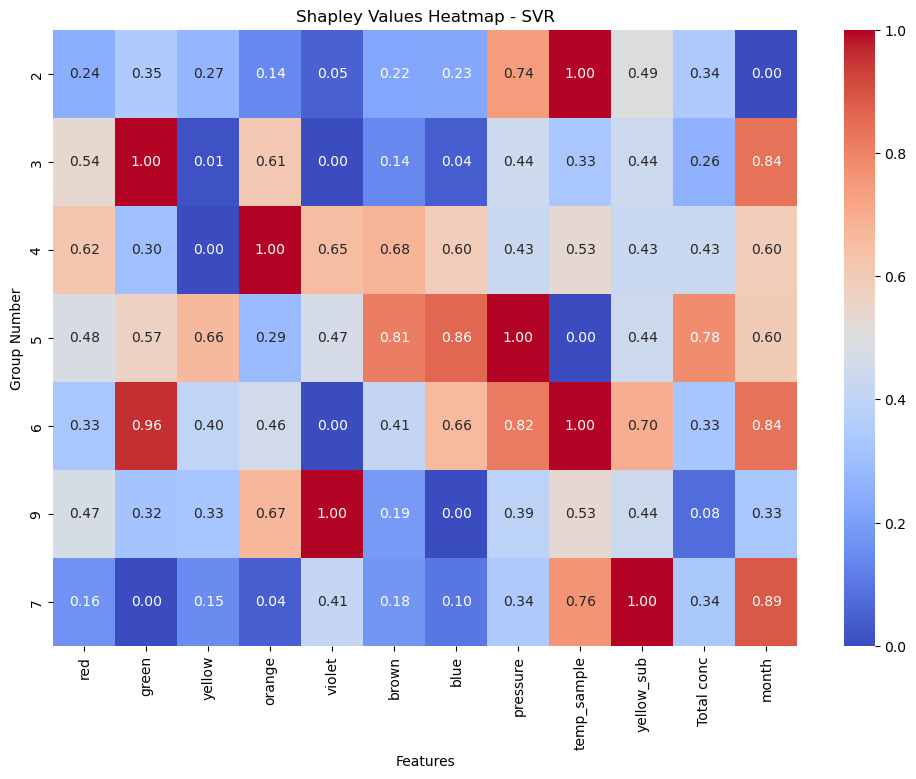

In [64]:
shap_heatmap(shap_values_list_svr, do_abs=False)